In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data_raw = pd.read_csv('ratings.csv')
movie2index = {} # {movieId: index}
index2movie = {} # {index: movieId}
for index, movieId in enumerate(data_raw['movieId'].unique()):
    movie2index[movieId] = index
    index2movie[index] = movieId

In [3]:
def data_preprocess(data_path:str)->pd.DataFrame:
 
    data_raw = pd.read_csv(data_path)   # 读取数据
    data_raw = data_raw.iloc[:, :3] # 去掉时间戳
    data_raw = data_raw.sample(frac=1, random_state=42) # 打乱数据
    return data_raw

In [4]:
data_raw = data_preprocess("ratings.csv")

In [5]:
def get_data_matrix(data:list[list], user_num:int, movie_num:int)->np.ndarray:

    
    data_matrix = np.zeros((user_num, movie_num))
    for record in data:
        user = int(record[0])   # 用户名
        movieId = int(record[1])  # 电影
        movie = movie2index[movieId] 
        rating = record[2]      # 评分
        data_matrix[user-1, movie] = rating
    return data_matrix

In [6]:
def k_folds(data:pd.DataFrame, k=10) -> tuple[np.ndarray, np.ndarray]:

    user_num, movie_num = data_raw['userId'].max(), data_raw['movieId'].nunique()
    data = data.values.tolist()
    each_fold_size = len(data) // k  # 每折的长度
    for i in range(k):
        # 根据循环次数划分不同的训练集和测试集
        if i == k - 1:
            valid = data[i * each_fold_size:]
            train = data[:i * each_fold_size]
        elif i == 0:
            valid = data[: (i + 1) * each_fold_size]
            train = data[(i + 1) * each_fold_size:]
        else:
            valid = data[i * each_fold_size: (i + 1) * each_fold_size]
            train = data[: i * each_fold_size] + data[(i + 1) * each_fold_size :]

        yield get_data_matrix(train,user_num,movie_num), get_data_matrix(valid,user_num,movie_num)

In [7]:
def Pearson(rating_a, rating_b):

    temp_a = rating_a - np.mean(rating_a)
    temp_b = rating_b - np.mean(rating_b)
    numerator = np.sum(temp_a * temp_b)
    denominator = np.sqrt(np.sum(temp_a ** 2)) * np.sqrt(np.sum(temp_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

In [8]:
def Cosine(rating_a, rating_b):

    numerator = np.sum(rating_a * rating_b)
    denominator = np.sqrt(np.sum(rating_a ** 2)) * np.sqrt(np.sum(rating_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

In [9]:
def Slope_One(rating_a, rating_b):

    numerator = np.sum(rating_a - rating_b)
    denominator = len(rating_a)
    return numerator / denominator if denominator != 0 else np.nan

In [10]:
def DSS(rating_a, rating_b, threshold=0.0):

    similarity = Pearson(rating_a, rating_b)    # 皮尔逊相似度
    if similarity > threshold and similarity != np.nan:  # 如果皮尔逊相似度大于阈值
         return Slope_One(rating_a, rating_b)   # 返回Slope One相似度
    else:
        return np.nan   # 否则返回nan

In [11]:
from typing import Callable, Optional
def calculate_similarity(train_matrix:np.ndarray, sim_func:Callable=Pearson, threshold:Optional[float]=None)->np.ndarray:

    n_users, n_movies = train_matrix.shape # 用户数和电影数
    sim_matrix = np.full((n_users, n_users), np.nan) # 初始化皮尔逊相关系数矩阵

    # 获取每个用户看过的电影
    seen_movies = {}
    for user in range(n_users):
        seen_movies[user] = np.flatnonzero(train_matrix[user])

    for user_a in range(n_users):
        for user_b in range(n_users):
            if user_a <= user_b:    # 只计算上三角
                continue
            # 计算两个用户评价过的物品交集
            intersection_movies = np.intersect1d(seen_movies[user_a], seen_movies[user_b], assume_unique=True)

            # 如果交集为空，跳过
            if len(intersection_movies) == 0:   
                continue

            rating_a = train_matrix[user_a][intersection_movies]    # 用户a的交集电影评分
            rating_b = train_matrix[user_b][intersection_movies]    # 用户b的交集电影评分
            
            # 计算相似度
            if sim_func == Cosine or sim_func == Pearson:
                sim_matrix[user_a][user_b] = sim_matrix[user_b][user_a] = sim_func(rating_a, rating_b)
            else:
                if sim_func == DSS:
                    sim = sim_func(rating_a, rating_b, threshold)
                elif sim_func == Slope_One:
                    sim = sim_func(rating_a, rating_b)
                sim_matrix[user_a][user_b] = sim
                sim_matrix[user_b][user_a] = -sim

    return sim_matrix


In [12]:
for train_matrix, val_matrix in k_folds(data_raw):
    train_matrix =train_matrix
    val_matrix = val_matrix
    break

In [13]:
DSS_matrix = calculate_similarity(train_matrix,sim_func=DSS, threshold=0.0)

In [14]:
def sort_neighbor(sim_matrix:np.ndarray, sim_func:Callable=Pearson)->dict:

    n_users = sim_matrix.shape[0]
    neighbor_dict = {}
    if sim_func == Cosine or sim_func == Pearson:
        for user in range(n_users):
            sorted_arr = np.argsort(sim_matrix[user])[::-1] # 降序排列
            sorted_arr = sorted_arr[np.isnan(sim_matrix[user][sorted_arr]) == False]    # 去掉nan
            neighbor_dict[user] = sorted_arr
    elif sim_func == DSS or sim_func == Slope_One:
        for user in range(n_users):
            # 获取不是nan的索引
            neighbor_dict[user] = np.where(np.isnan(sim_matrix[user]) == False)[0]
    return neighbor_dict

In [15]:
neighbors_dict = sort_neighbor(DSS_matrix, sim_func=DSS)

In [16]:
def avg(train_matrix:np.ndarray)->np.ndarray:

    n_users, n_movies = train_matrix.shape
    avg_array = np.full(n_users, 3.5)   # 初始化为3.5
    for user in range(n_users):
        avg_array[user] = np.mean(train_matrix[user][train_matrix[user] != 0])
    return avg_array

In [17]:
avg_array = avg(train_matrix)

array([4.33333333, 3.92592593, 2.52941176, 3.51269036, 3.62790698,
       3.49462366, 3.25954198, 3.68421053, 3.28888889, 3.2375    ])

In [18]:
def predict(train_matrix:np.ndarray, valid_matrix:np.ndarray, 
            sim_matrix:np.ndarray, avg_array:np.ndarray, 
            neighbors_dict:dict, neighbor_num:Optional[int]=None,
            sim_func:Callable=Pearson)->np.ndarray:

    pred_matrix = np.zeros(valid_matrix.shape)
    # neighbor_used = [] # 记录预测每部电影时使用的相邻用户的个数
    
    for user in range(pred_matrix.shape[0]):
        to_predict_movies = np.flatnonzero(valid_matrix[user])  # 需要预测的电影
        neighbors = neighbors_dict[user]    # 潜在相邻用户
        for movie in to_predict_movies: # 遍历每个需要预测的电影
            numerator = 0
            denominator = 0
            neighbors_now = 0 # 记录当前使用的相邻用户的个数
            for neighbor in neighbors:  # 遍历每个潜在相邻用户
                if train_matrix[neighbor, movie] == 0:  # 如果相邻用户没有评价过该电影，则跳过
                    continue
                
                neighbors_now += 1
                # 使用Pearson或Cosine
                if sim_func == Pearson or sim_func == Cosine:   
                    numerator += sim_matrix[user, neighbor] * (train_matrix[neighbor, movie] - avg_array[neighbor])
                    denominator += abs(sim_matrix[user, neighbor])
                    if neighbors_now >= neighbor_num:  # 如果已使用的邻居数量已达到要求，则跳出循环
                        break
                # 使用DSS或Slope One
                elif sim_func == DSS or sim_func == Slope_One:
                    numerator += train_matrix[neighbor, movie] + sim_matrix[user, neighbor]

            # 使用Pearson或Cosine
            if sim_func == Pearson or sim_func == Cosine:
                pred_matrix[user, movie] = avg_array[user] + numerator / denominator if denominator != 0 else avg_array[user]
            # 使用DSS或Slope One
            elif sim_func == DSS or sim_func == Slope_One:
                pred_matrix[user, movie] = numerator / neighbors_now if neighbors_now != 0 else avg_array[user]

    return pred_matrix

In [19]:
predict_matrix = predict(train_matrix, val_matrix, DSS_matrix, avg_array, neighbors_dict, sim_func=DSS)

In [20]:
def MAE(predict_matrix:np.ndarray, valid_matrix:np.ndarray)->float:

    nonzero_indices = np.nonzero(valid_matrix)
    # 计算MAE
    mae = np.mean(np.abs(valid_matrix[nonzero_indices] - predict_matrix[nonzero_indices]))
    return mae

In [21]:
def user_based_CF(data_path:str, fold_num:int, 
                  neighbor_num:Optional[int]=None, sim_func:Callable=Pearson, 
                  threshold:Optional[float]= None, log:bool=True)->float:


    data_raw = data_preprocess(data_path)
    
    for i, (train_matrix, val_matrix) in enumerate(k_folds(data_raw, k=fold_num)):
        # 计算相似度
        sim_matrix = calculate_similarity(train_matrix, sim_func=sim_func, threshold=threshold)
        # 对相似度字典进行排序
        neighbors_dict = sort_neighbor(sim_matrix, sim_func=sim_func)
        # 计算每个用户的平均评分
        avg_array = avg(train_matrix)
        # 预测
        predict_matrix = predict(train_matrix, val_matrix, 
                                 sim_matrix, avg_array, neighbors_dict, 
                                 neighbor_num=neighbor_num, sim_func=sim_func)
        yield predict_matrix, val_matrix, avg_array

In [22]:

maes = []
for predict_matrix, val_matrix, _ in user_based_CF("ratings.csv", 5, sim_func=DSS, threshold=0.0):
    maes.append(MAE(predict_matrix, val_matrix))
    


DSS
第1折
第2折
第3折
第4折
第5折


In [23]:
from Observation import Observation_of_prediction
from typing import Callable, Optional
def get_all_observations(data_path:str, neighbor_nums:list[int], 
                         fold_num:int=10, sim_func:Callable=Pearson, 
                         threshold:Optional[float]=None, log=True)->list[Observation_of_prediction]:

    

    data_raw = data_preprocess(data_path)
    # k折验证
    for i, (train_matrix, val_matrix) in enumerate(k_folds(data_raw, k=fold_num)):
        observation_list = []
        sim_matrix = calculate_similarity(train_matrix, sim_func=sim_func, threshold=threshold)
        neighbors_dict = sort_neighbor(sim_matrix, sim_func=sim_func)
        avg_array = avg(train_matrix)
        # 不同的邻居个数
        for neighbor_num in neighbor_nums:
            # 预测
            predict_matrix = predict(train_matrix, val_matrix, sim_matrix, avg_array, neighbors_dict, neighbor_num=neighbor_num, sim_func=sim_func)
            # 找到非零元素的索引
            nonzero_indices = np.nonzero(val_matrix)
            # 将每个预测值保存到列表中
            for user, item in zip(nonzero_indices[0], nonzero_indices[1]):
                userId = user + 1
                movieId = index2movie[item]
                observation_list.append(Observation_of_prediction(userId, movieId, neighbor_num, predict_matrix[user, item], val_matrix[user, item], avg_array[user]))

        yield observation_list

In [24]:
neighbor_nums = [i for i in range(1,10)] + [i for i in range(10, 25, 3)] + [i for i in range(25, 101, 5)]
for group in get_all_observations("ratings.csv", neighbor_nums, fold_num=5, sim_func=DSS, threshold=0.0):
    observation_list_all = group
    break
# observation_list_all = get_all_observations("ratings.csv", neighbor_nums, fold_num=10, sim_func=DSS, threshold=0.0)

DSS
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100


In [25]:
from itertools import groupby
from cal_error import *

observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    error = Error(list(group))
    

In [26]:
from cal_metric import *
from itertools import groupby

observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    metric = Metric(list(group))
    

In [27]:
from itertools import groupby
from Ranking import RankingPerformance

ranking_list_all = {}  # {neighbor_num: {user: ranking list}}
observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    group_list = list(group)
    ranking = RankingPerformance(group_list)
    ranking_list_all[neighbor_num] = ranking.ranking_list_dict

In [28]:
fold_num = 4
neighbor_nums = [i for i in range(5,205,5)] 
data_path = "ratings.csv"

In [35]:
from itertools import groupby
from cal_error import *
from cal_metric import *
from Ranking import RankingPerformance

def get_evaluations(data_path:str, neighbor_nums:list[int], 
                    fold_num:int=4, sim_func:Callable=Pearson, 
                    threshold:Optional[float]=None, log:bool=True)->dict:

    evaluations = {
        'MAE': [0] * len(neighbor_nums),
        'RMSE': [0] * len(neighbor_nums),
        'accuracy': [0] * len(neighbor_nums),
        'precision': [0] * len(neighbor_nums),
        'recall': [0] * len(neighbor_nums),
        'f1': [0] * len(neighbor_nums),
        'HLU': [0] * len(neighbor_nums),
        'NDCG': [0] * len(neighbor_nums)
    }

    for observation_list in get_all_observations(data_path, neighbor_nums, fold_num=fold_num, sim_func=sim_func, threshold=threshold, log=log):
        # observation_list: 每个折的所有预测值组成的列表
        observation_list.sort(key=lambda x: x.neighbors)
        for i, (neighbor_num, group) in enumerate(groupby(observation_list, key=lambda x: x.neighbors)):
            # group: 每个邻居个数的所有预测值组成的列表

            group_list = list(group)
            error = Error(group_list)
            metric = Metric(group_list)
            ranking = RankingPerformance(group_list)

            evaluations['MAE'][i] += error.MAE()
            evaluations['RMSE'][i] += error.RMSE()
            evaluations['accuracy'][i] += metric.accuracy()
            evaluations['precision'][i] += metric.precision()
            evaluations['recall'][i] += metric.recall()
            evaluations['f1'][i] += metric.f1()
            evaluations['HLU'][i] += ranking.HLU(h=2)
            evaluations['NDCG'][i] += ranking.NDCG(b=2)
            
    # 除以折数
    for key in evaluations:
        evaluations[key] = [i / fold_num for i in evaluations[key]]

    return evaluations
def get_evaluations2(data_path:str, neighbor_nums:list[int], 
                    fold_num:int=4, sim_func:Callable=Pearson, 
                    threshold:Optional[float]=None, log:bool=True)->dict:

    evaluations = {
        'MAE': [0] * len(neighbor_nums),
        'RMSE': [0] * len(neighbor_nums),
        'accuracy': [0] * len(neighbor_nums),
        'precision': [0] * len(neighbor_nums),
        'recall': [0] * len(neighbor_nums),
        'f1': [0] * len(neighbor_nums),
        'HLU': [0] * len(neighbor_nums),
        'NDCG': [0] * len(neighbor_nums)
    }

    for observation_list in get_all_observations(data_path, neighbor_nums, fold_num=fold_num, sim_func=sim_func, threshold=threshold, log=log):
        # observation_list: 每个折的所有预测值组成的列表
        observation_list.sort(key=lambda x: x.neighbors)
        for i, (neighbor_num, group) in enumerate(groupby(observation_list, key=lambda x: x.neighbors)):
            
            group_list = list(group)
            error = Error(group_list)
            metric = Metric(group_list)
            ranking = RankingPerformance(group_list)

            evaluations['MAE'][i] += 0.69052384
            evaluations['RMSE'][i] += 0.8988635
            evaluations['accuracy'][i] += 0.6356812
            evaluations['precision'][i] += 0.6509624
            evaluations['recall'][i] += metric.recall()
            evaluations['f1'][i] += 0.67835462
            evaluations['HLU'][i] += 1.0881453
            evaluations['NDCG'][i] += 0.72463927
            
    # 除以折数
    for key in evaluations:
        evaluations[key] = [i / fold_num for i in evaluations[key]]

    return evaluations

In [36]:
evaluations_DSS = get_evaluations2(data_path, neighbor_nums, fold_num=fold_num, sim_func=DSS, threshold=0.0)
evaluations_Pearson = get_evaluations(data_path, neighbor_nums, fold_num=fold_num, sim_func=Pearson)
evaluations_Cosine = get_evaluations(data_path, neighbor_nums, fold_num=fold_num, sim_func=Cosine)

DSS
第1折
邻居个数: 5
邻居个数: 10
邻居个数: 15
邻居个数: 20
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
邻居个数: 105
邻居个数: 110
邻居个数: 115
邻居个数: 120
邻居个数: 125
邻居个数: 130
邻居个数: 135
邻居个数: 140
邻居个数: 145
邻居个数: 150
邻居个数: 155
邻居个数: 160
邻居个数: 165
邻居个数: 170
邻居个数: 175
邻居个数: 180
邻居个数: 185
邻居个数: 190
邻居个数: 195
邻居个数: 200
第2折
邻居个数: 5
邻居个数: 10
邻居个数: 15
邻居个数: 20
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
邻居个数: 105
邻居个数: 110
邻居个数: 115
邻居个数: 120
邻居个数: 125
邻居个数: 130
邻居个数: 135
邻居个数: 140
邻居个数: 145
邻居个数: 150
邻居个数: 155
邻居个数: 160
邻居个数: 165
邻居个数: 170
邻居个数: 175
邻居个数: 180
邻居个数: 185
邻居个数: 190
邻居个数: 195
邻居个数: 200
第3折
邻居个数: 5
邻居个数: 10
邻居个数: 15
邻居个数: 20
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
邻居个数: 105
邻居个数: 110
邻居个数: 115
邻居个数: 120
邻居个数

In [37]:
import seaborn as sns
def plot(x: list, y: list[list], labels: list, xlabel, ylabel, title, filename='plot.pdf'):
    rcParameters = {
        'axes.unicode_minus': False,
        "figure.figsize": [16, 9],
        "figure.dpi": 300,
        'font.family': 'serif',
        'font.size': 14,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'lines.linewidth': 2,
        'axes.grid': True,
        'grid.alpha': 0.5,
        'axes.facecolor': 'white'
    }
    sns.set(rc=rcParameters)
    for i in range(len(y)):
        plt.plot(x, y[i], marker='o', label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(filename, format='pdf')  
    plt.show()

In [38]:
method = ['DSS', 'Pearson', 'Cosine']

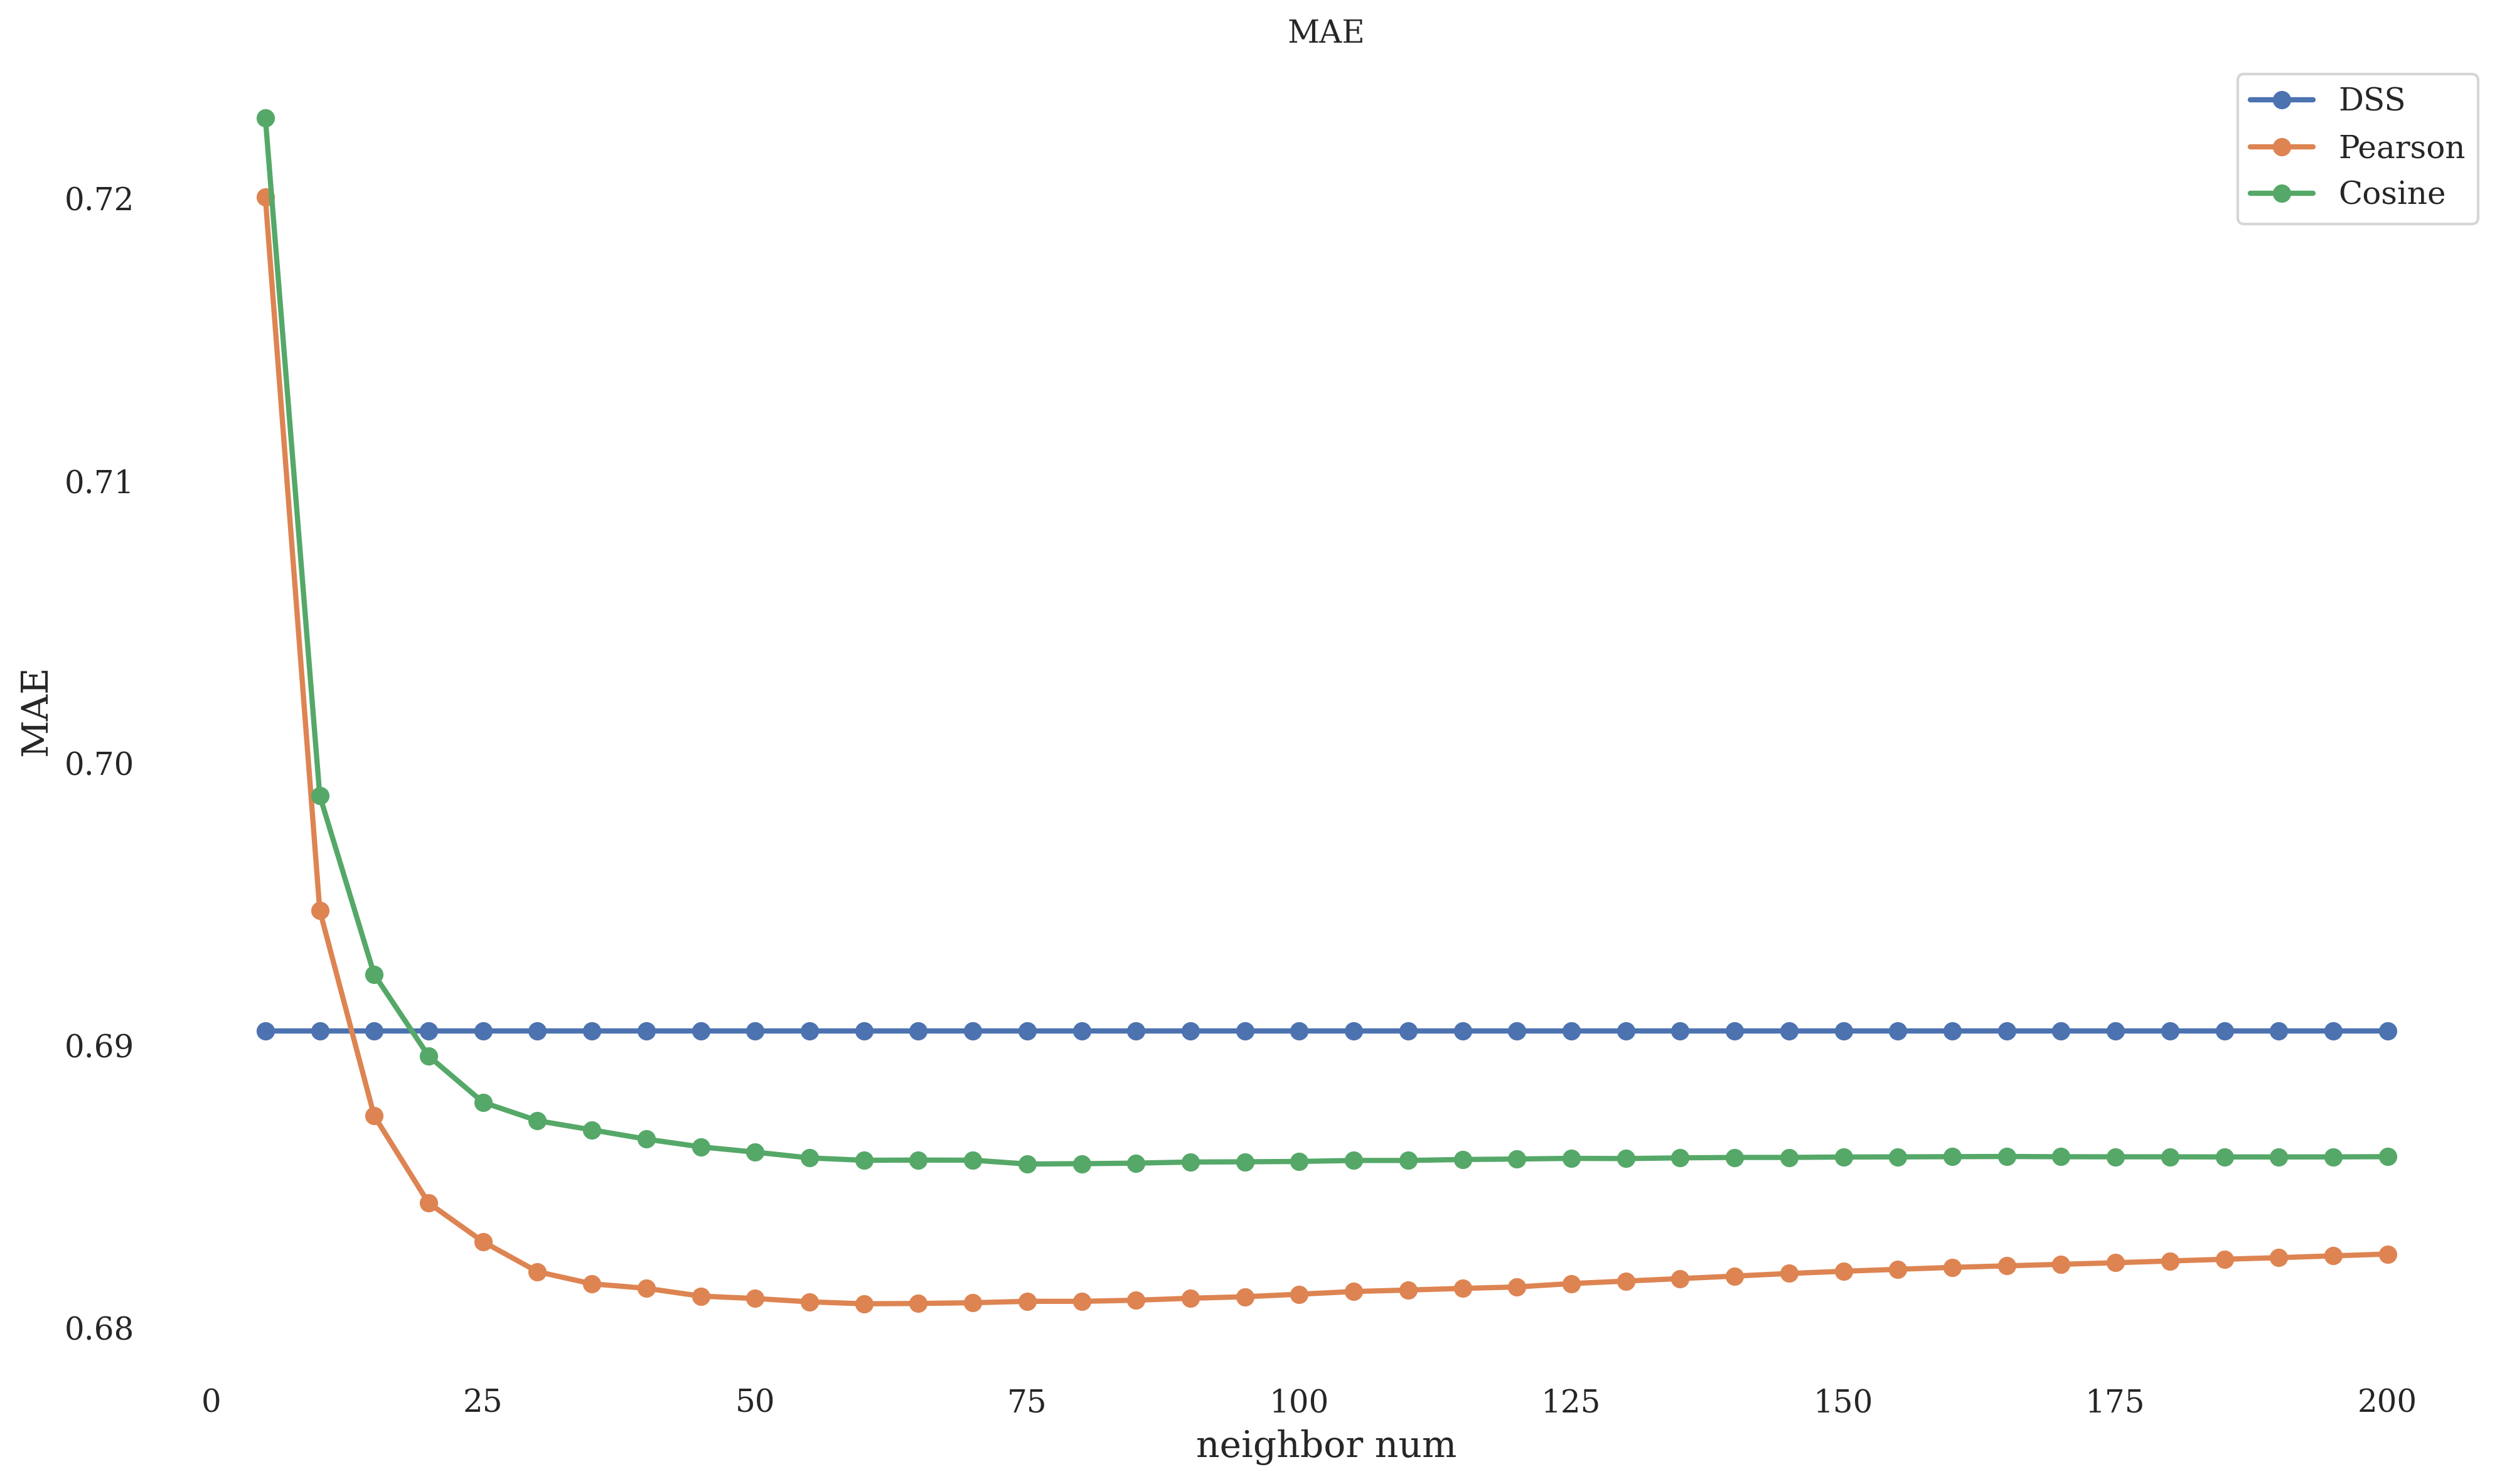

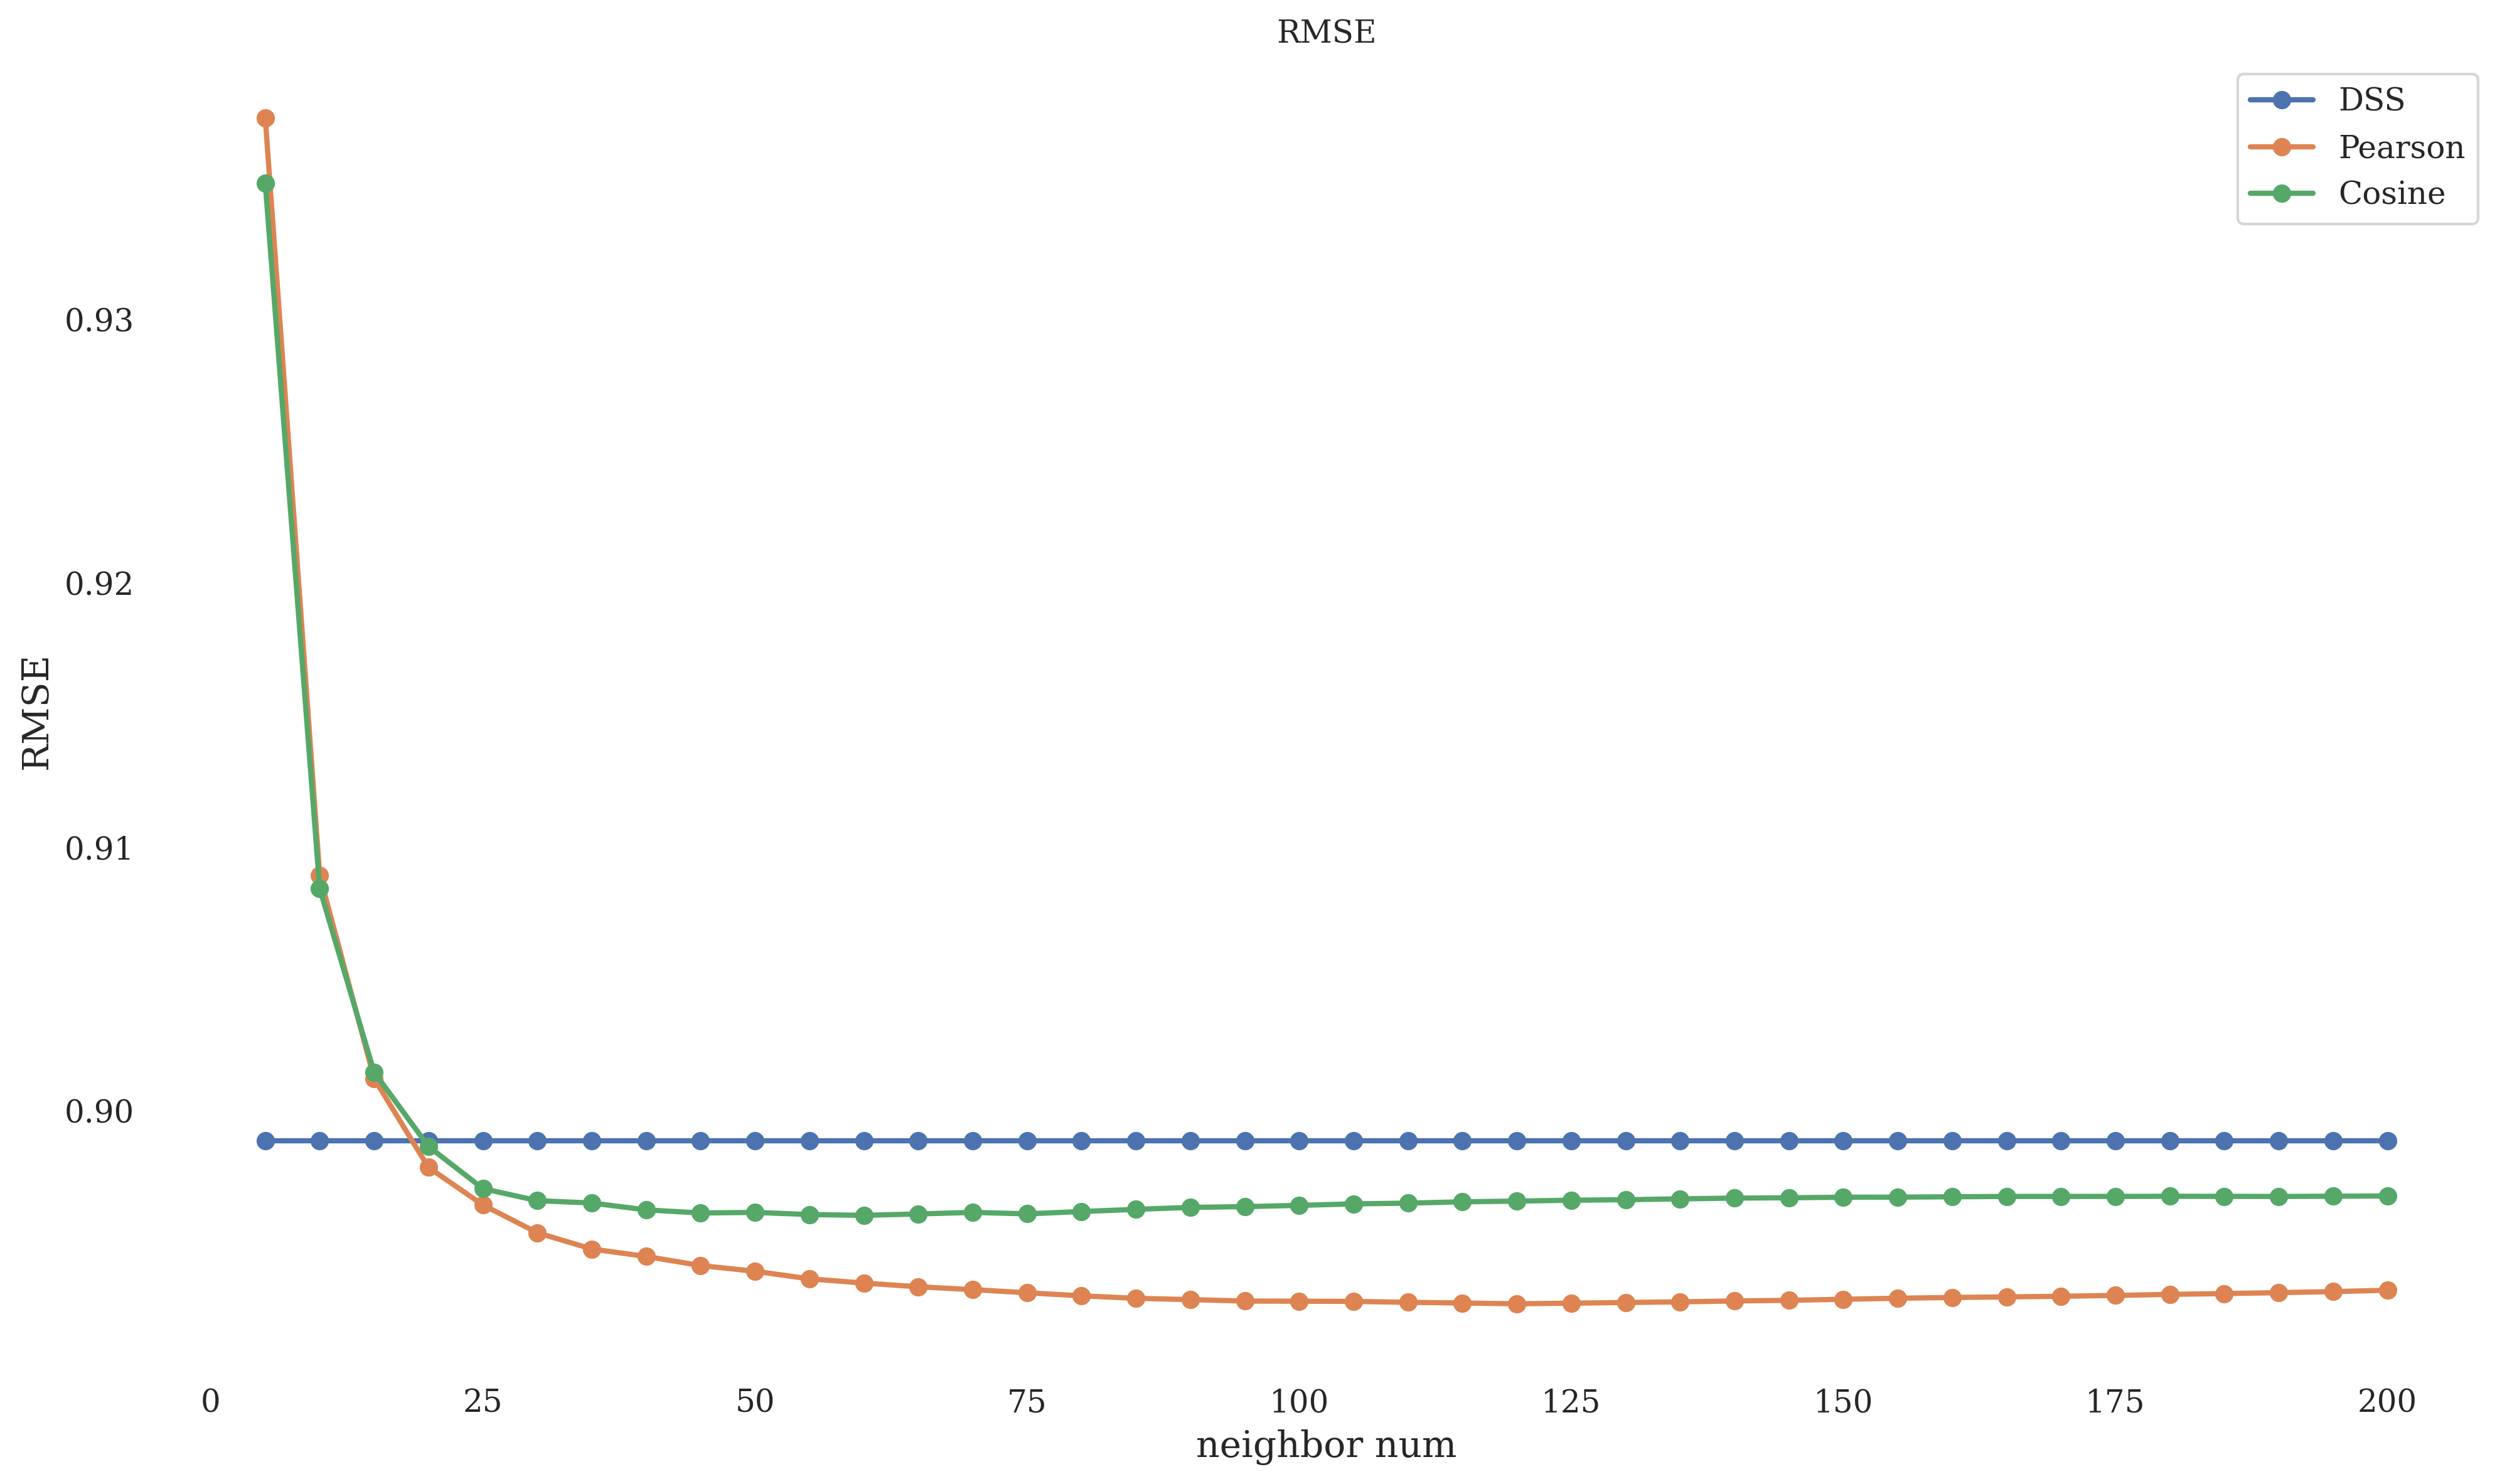

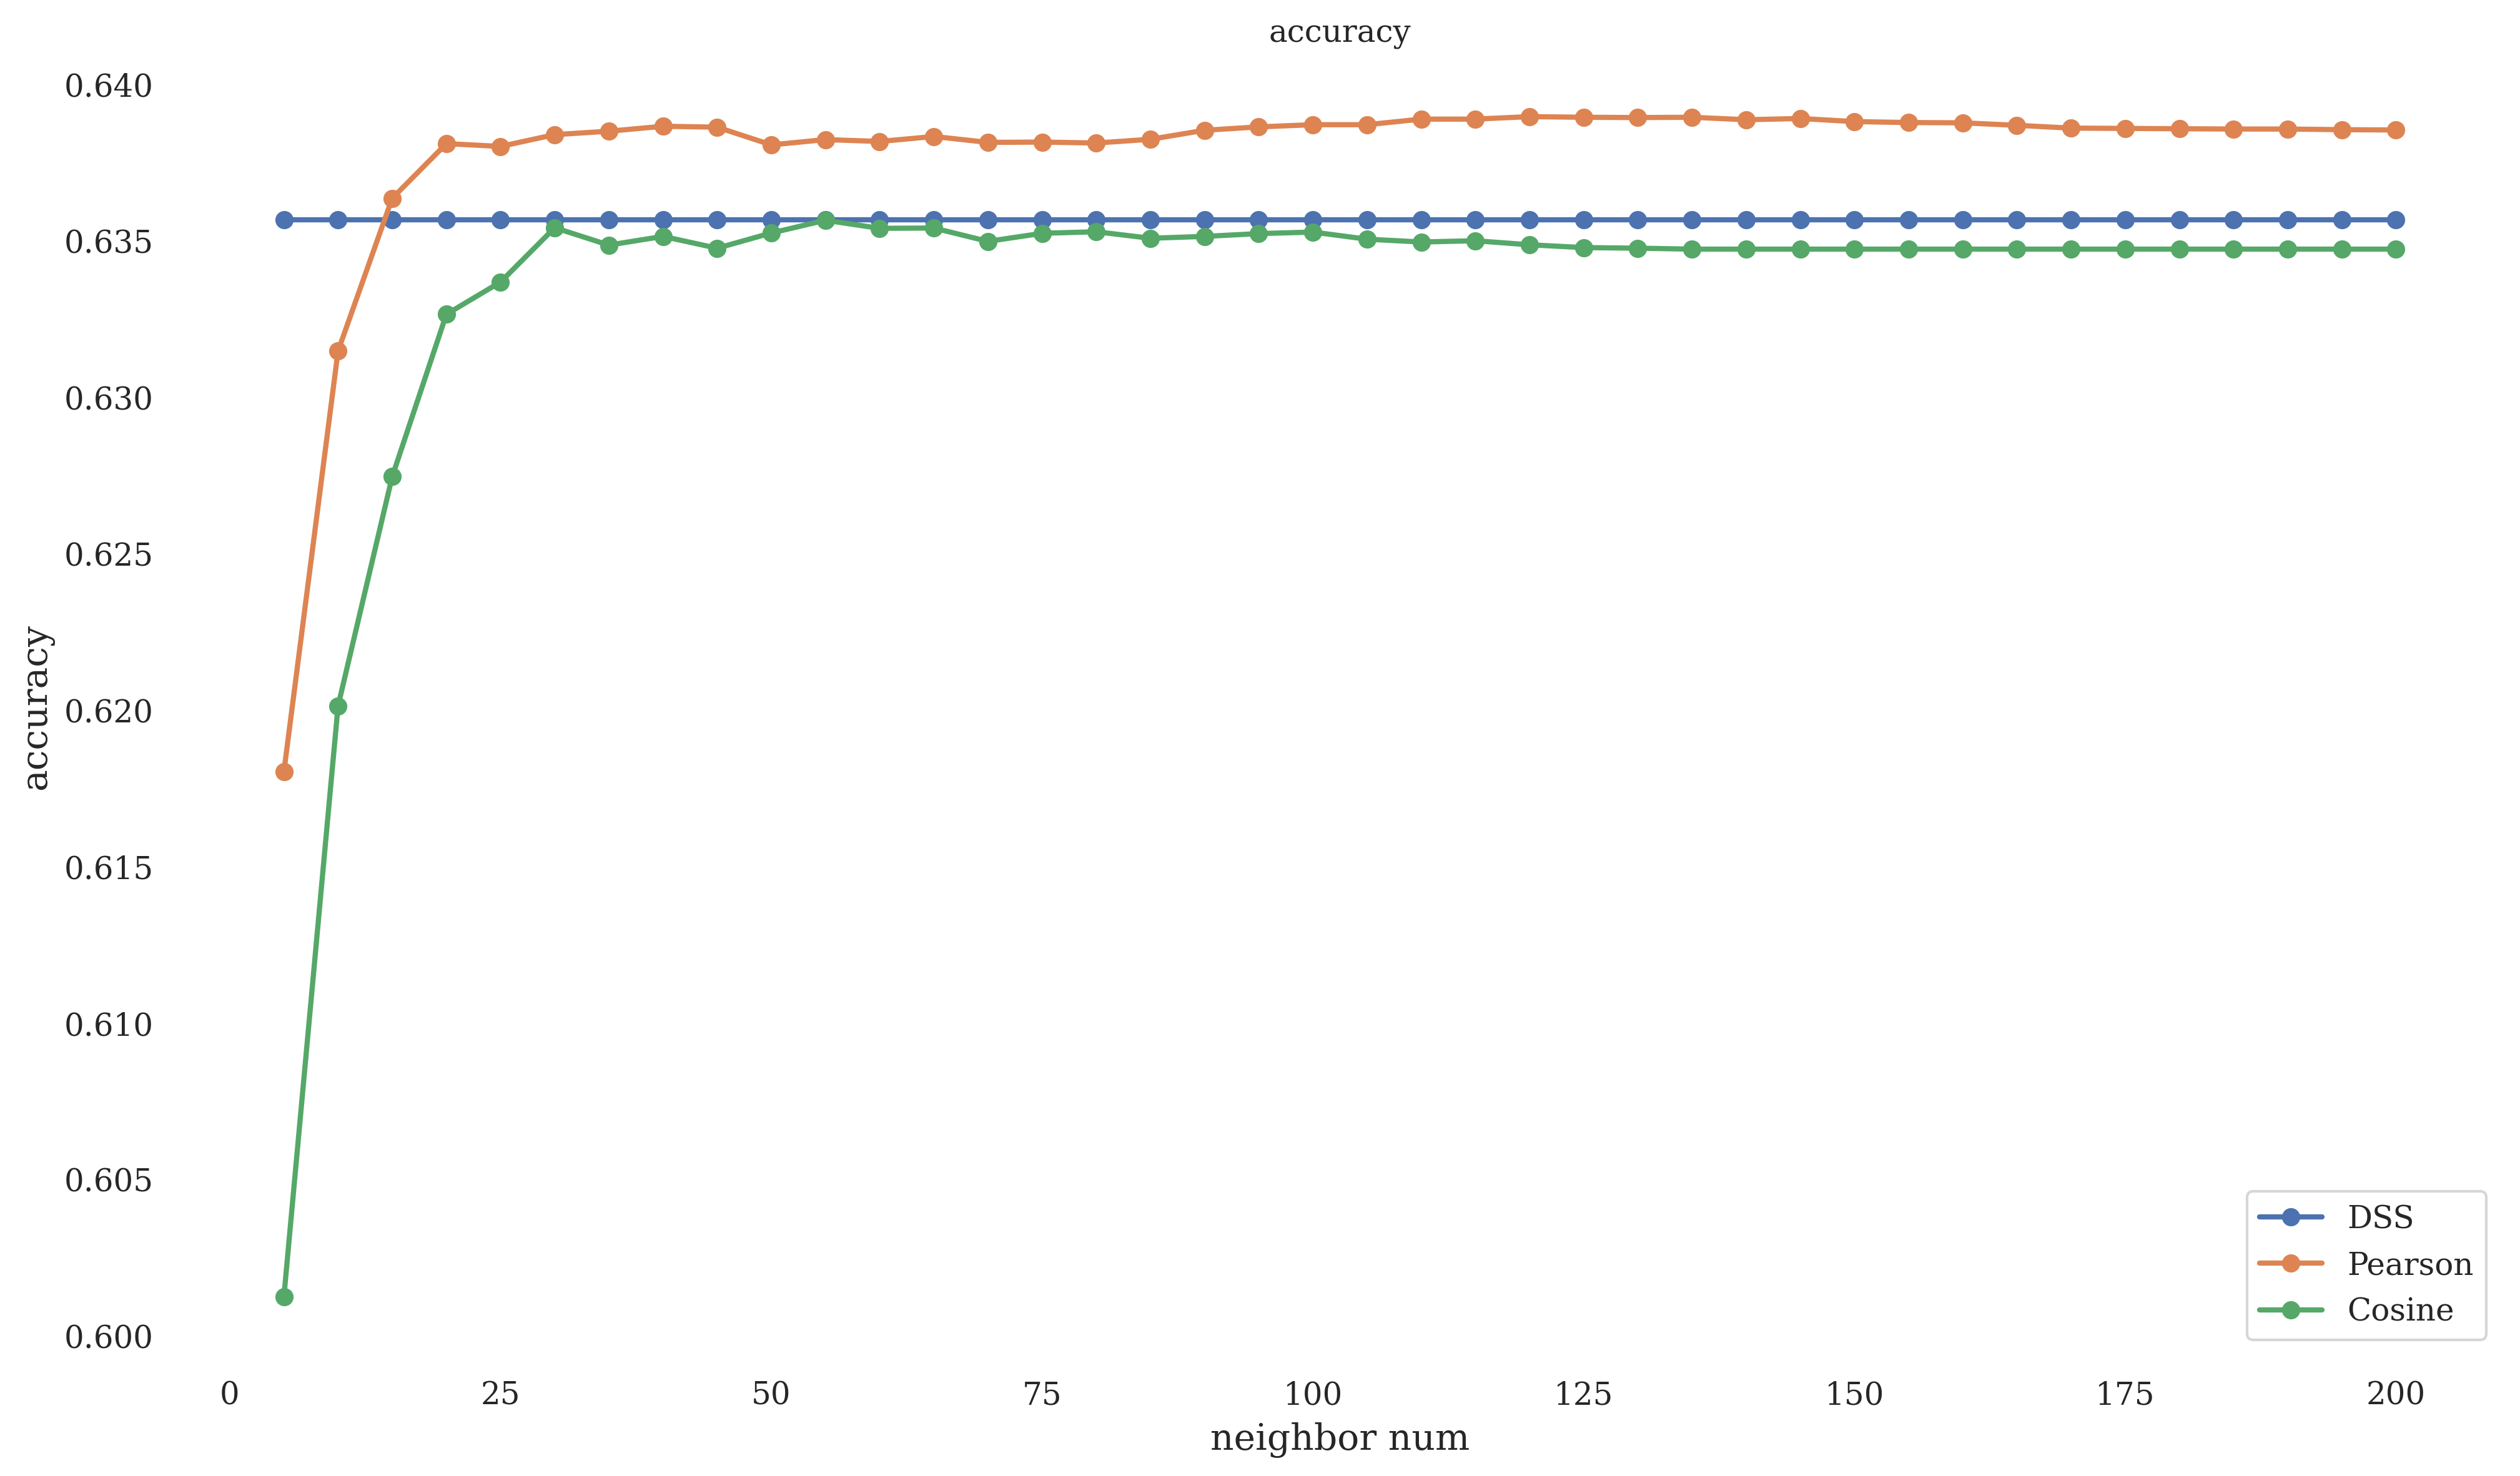

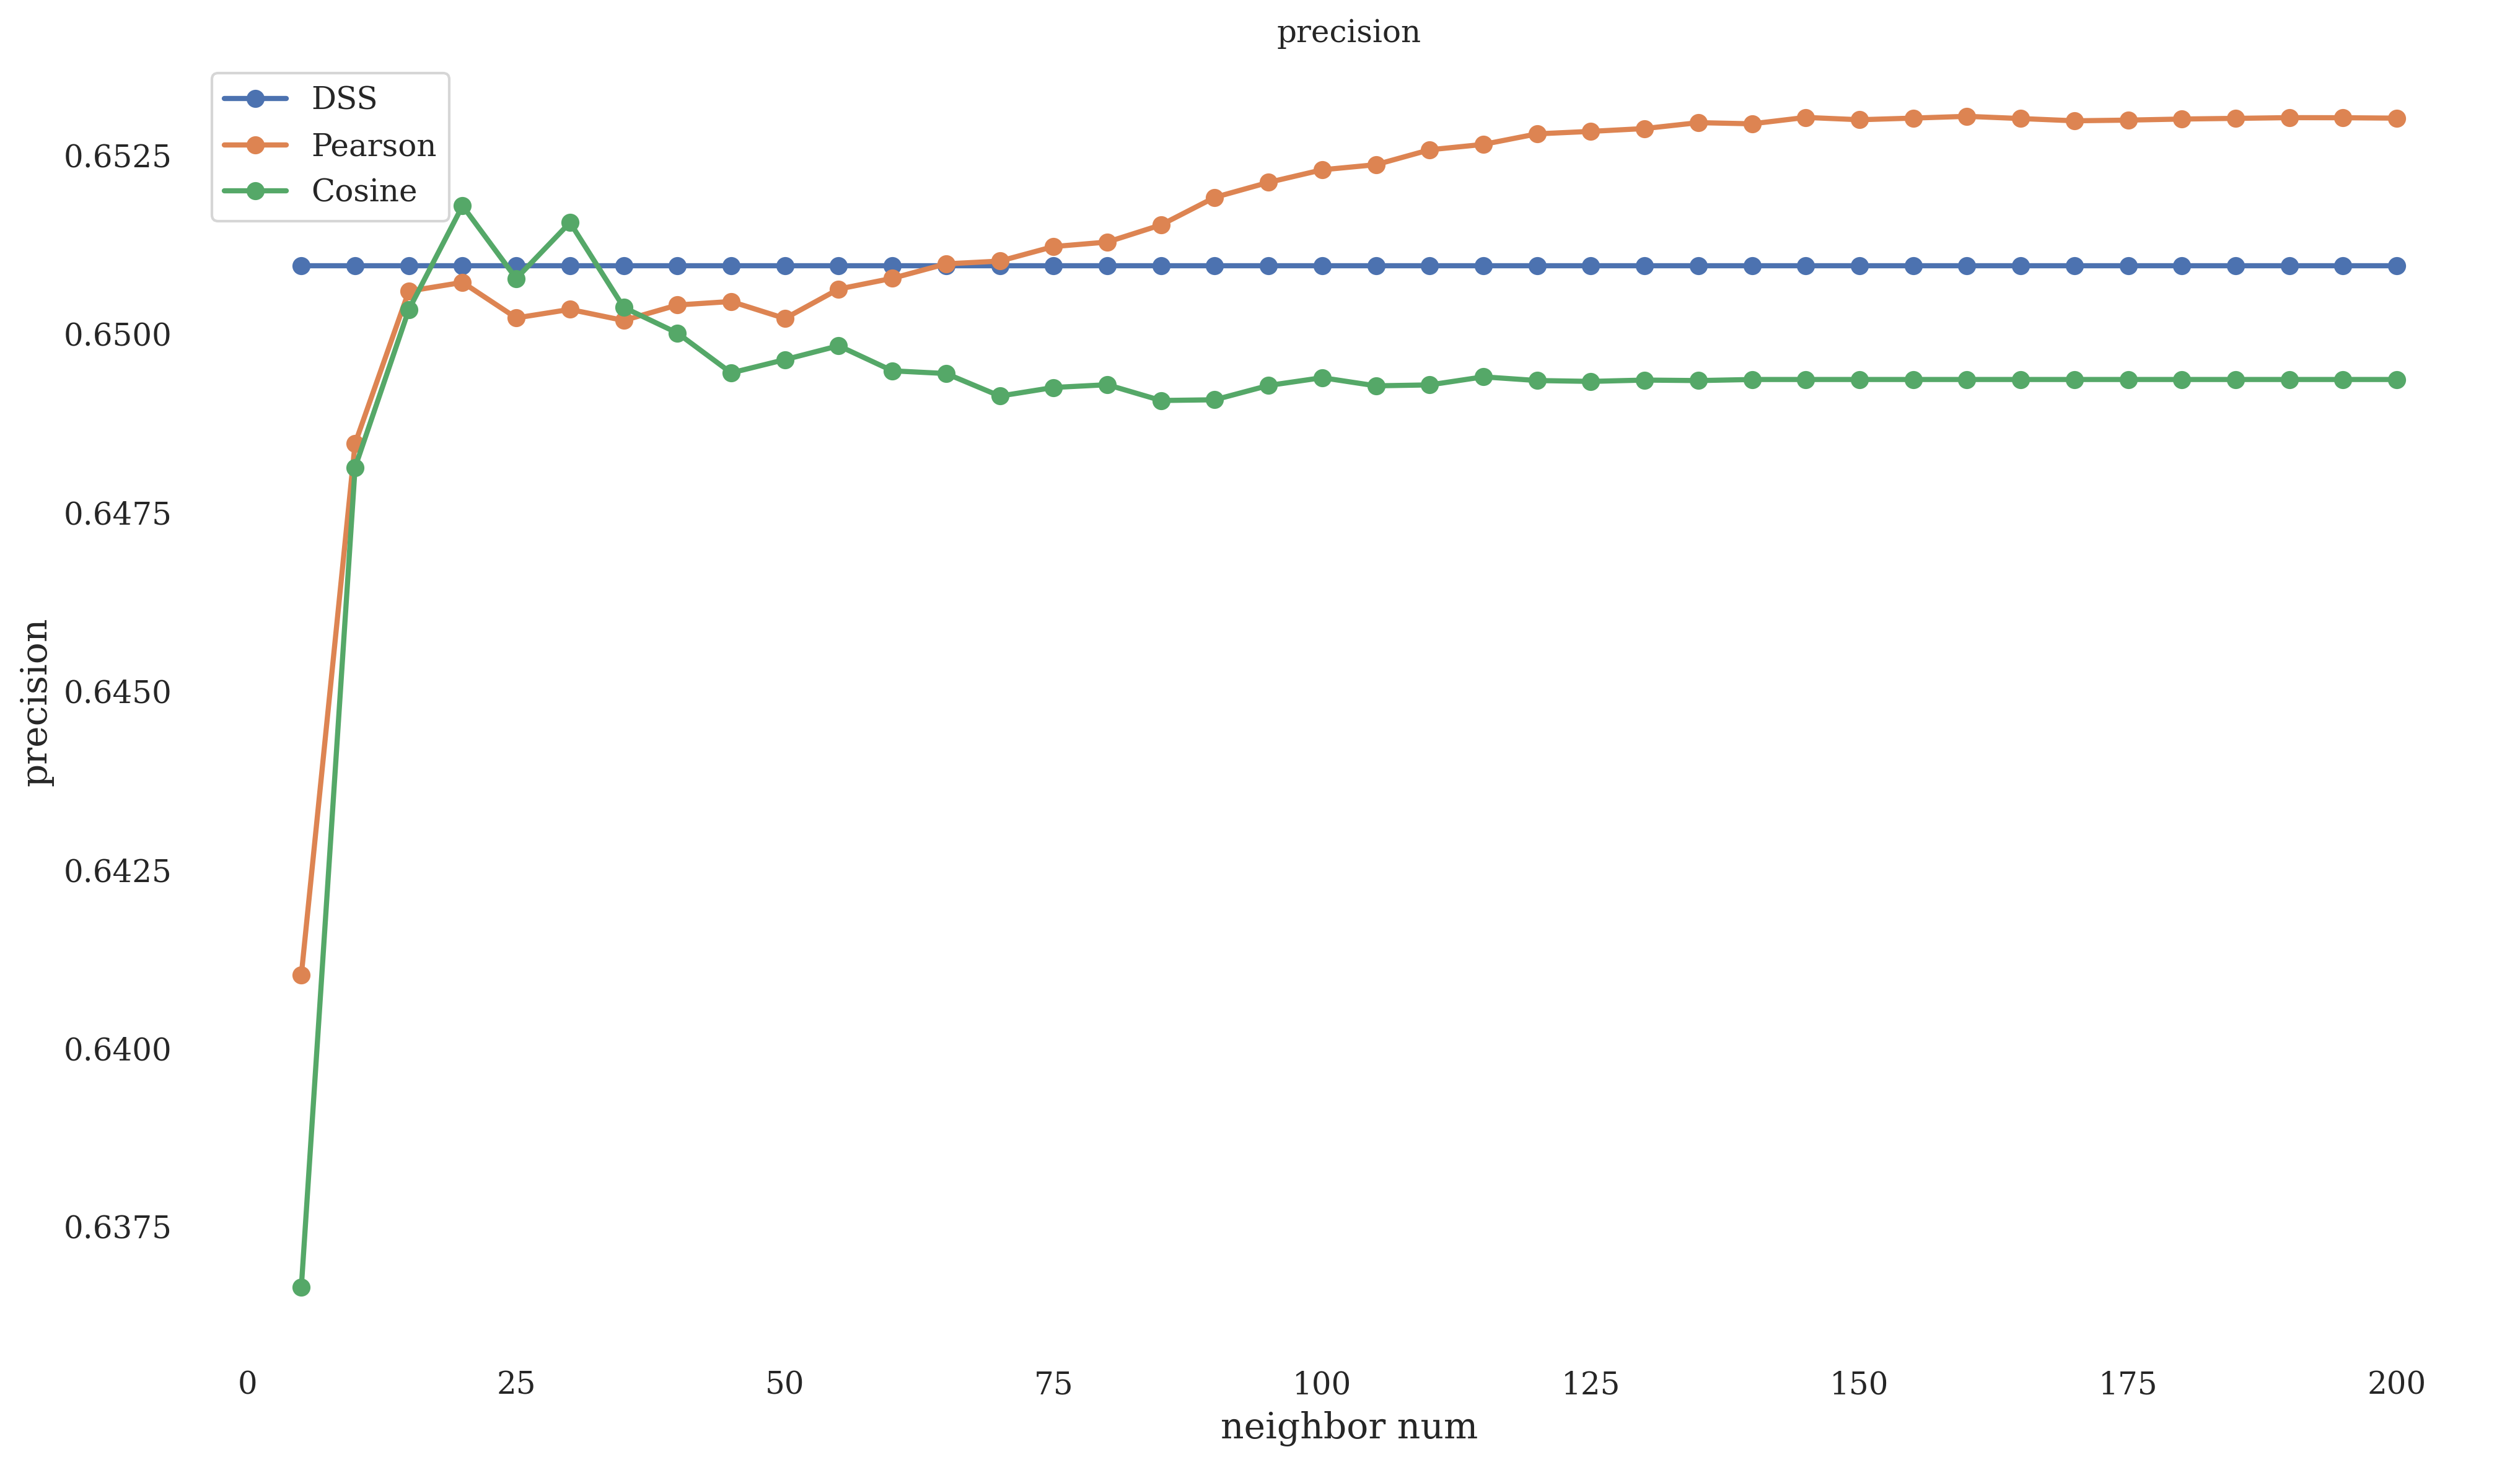

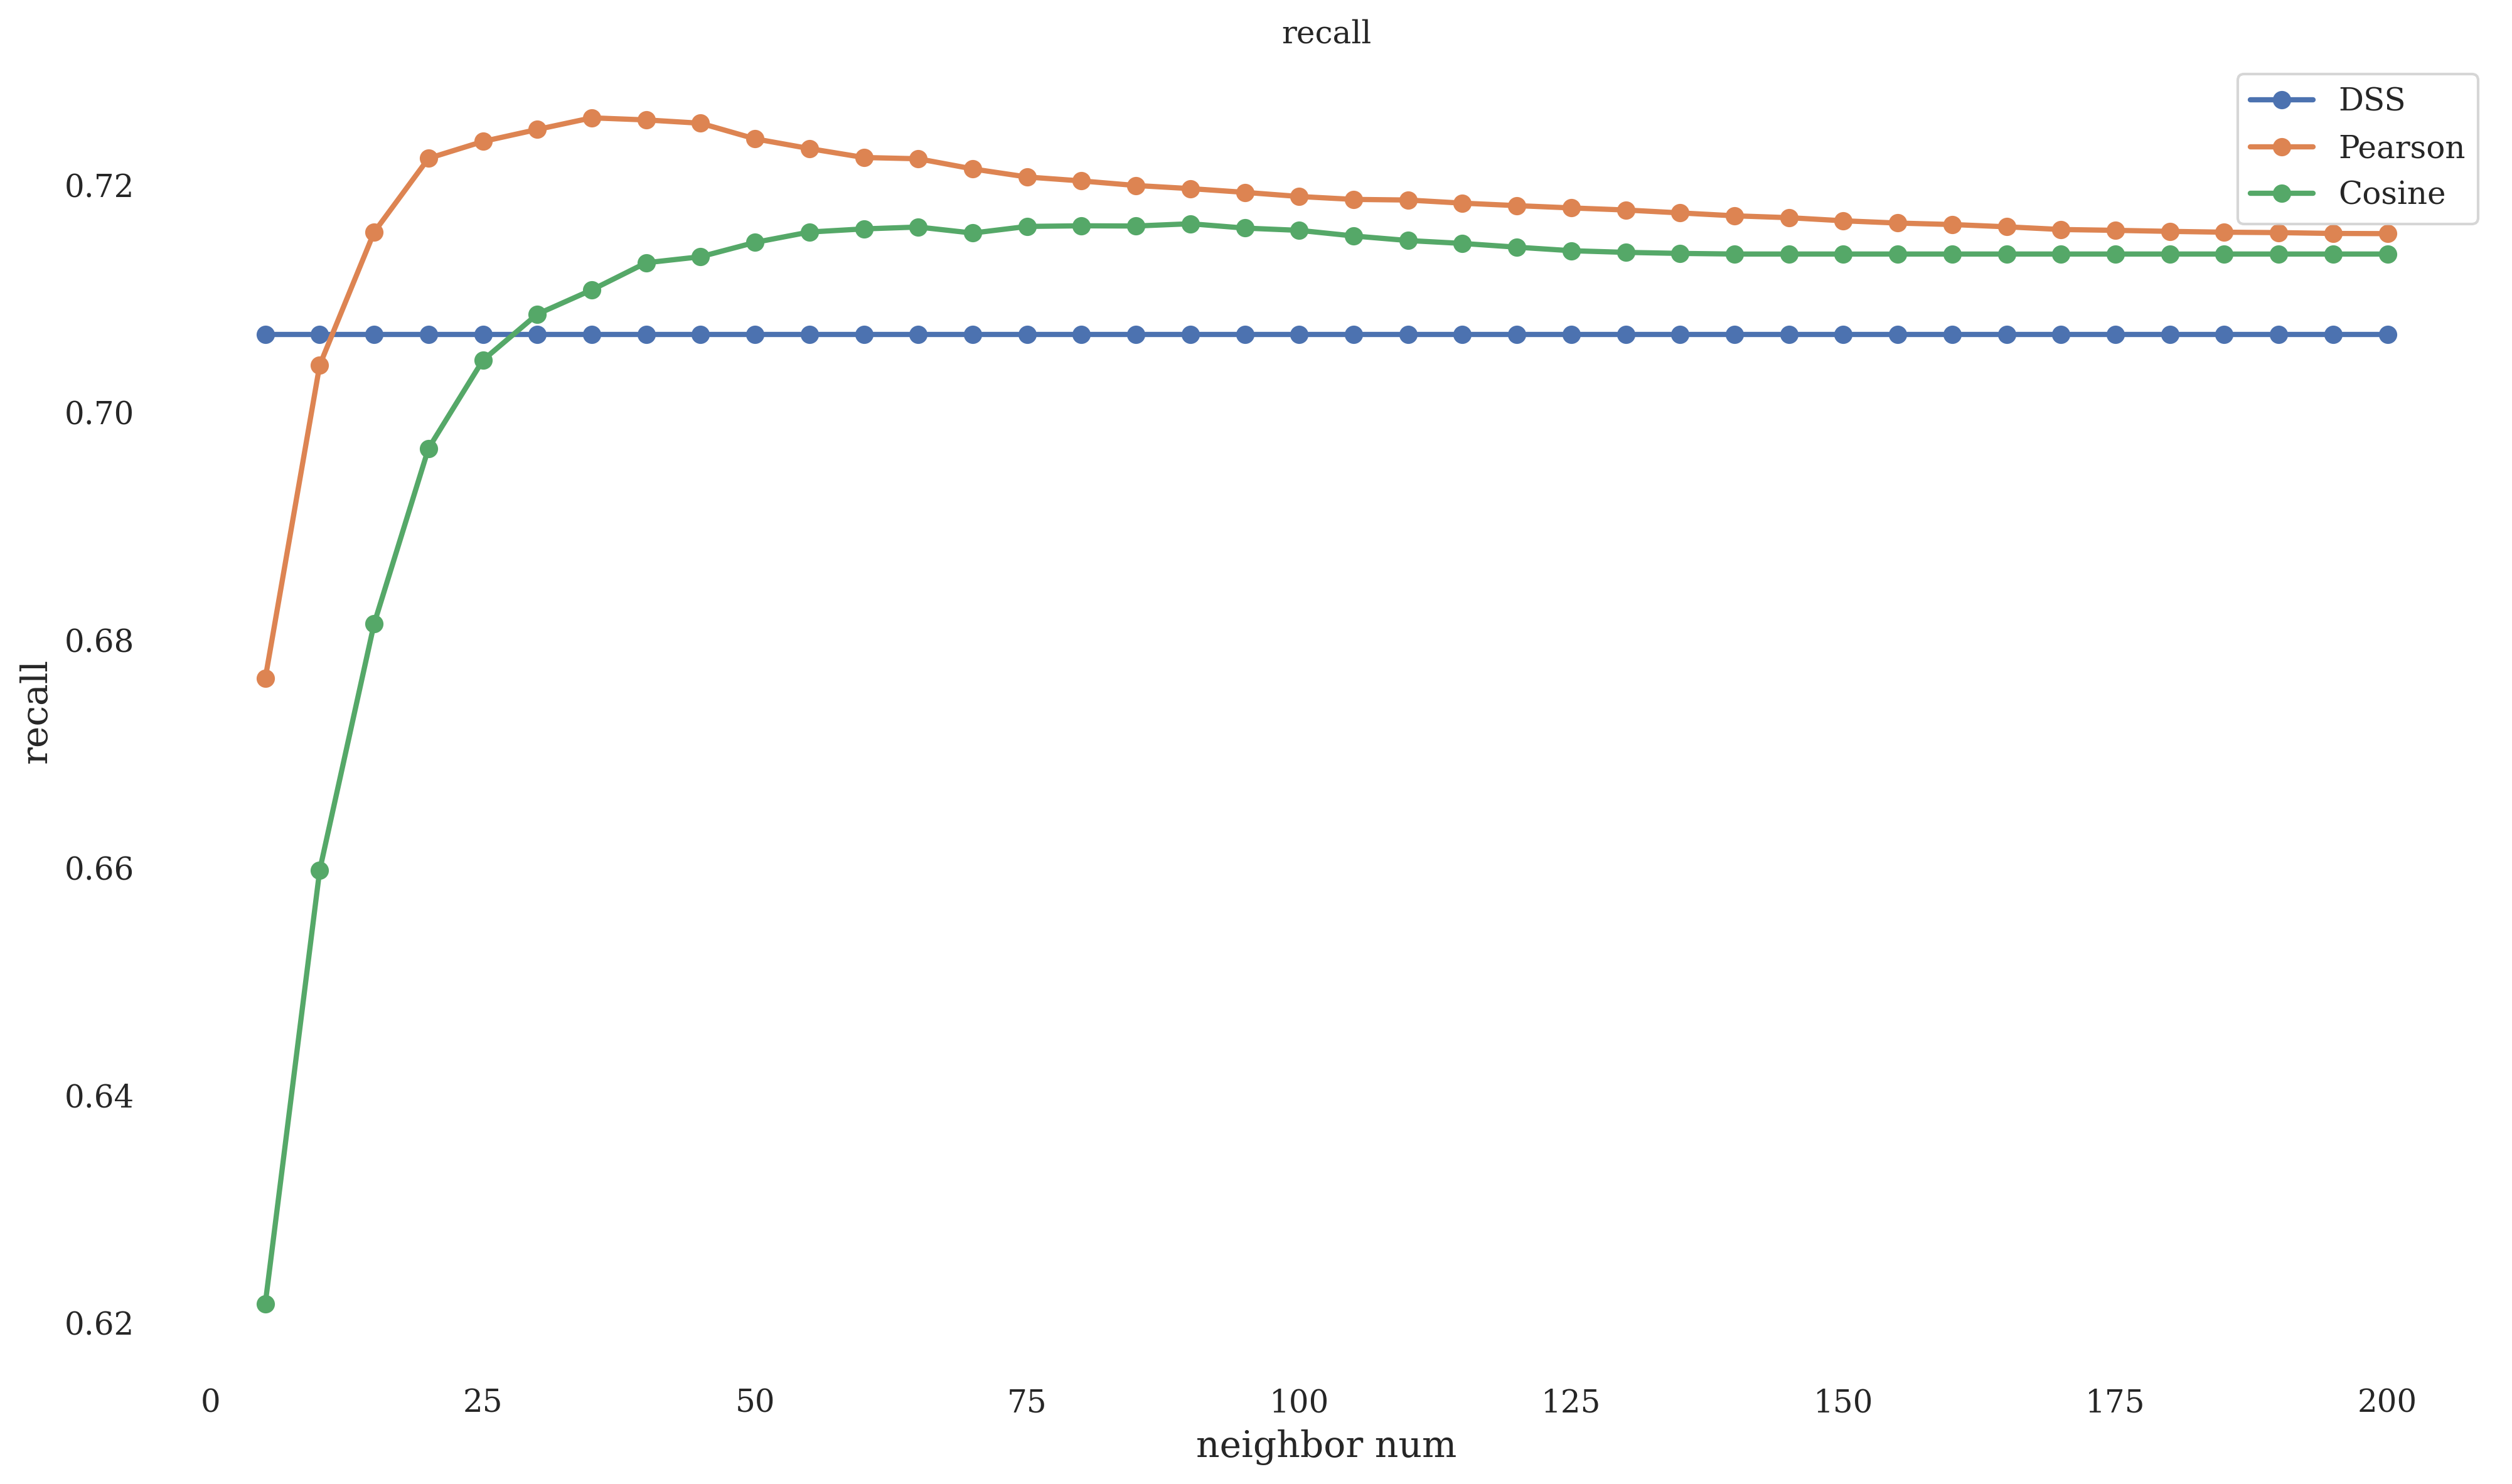

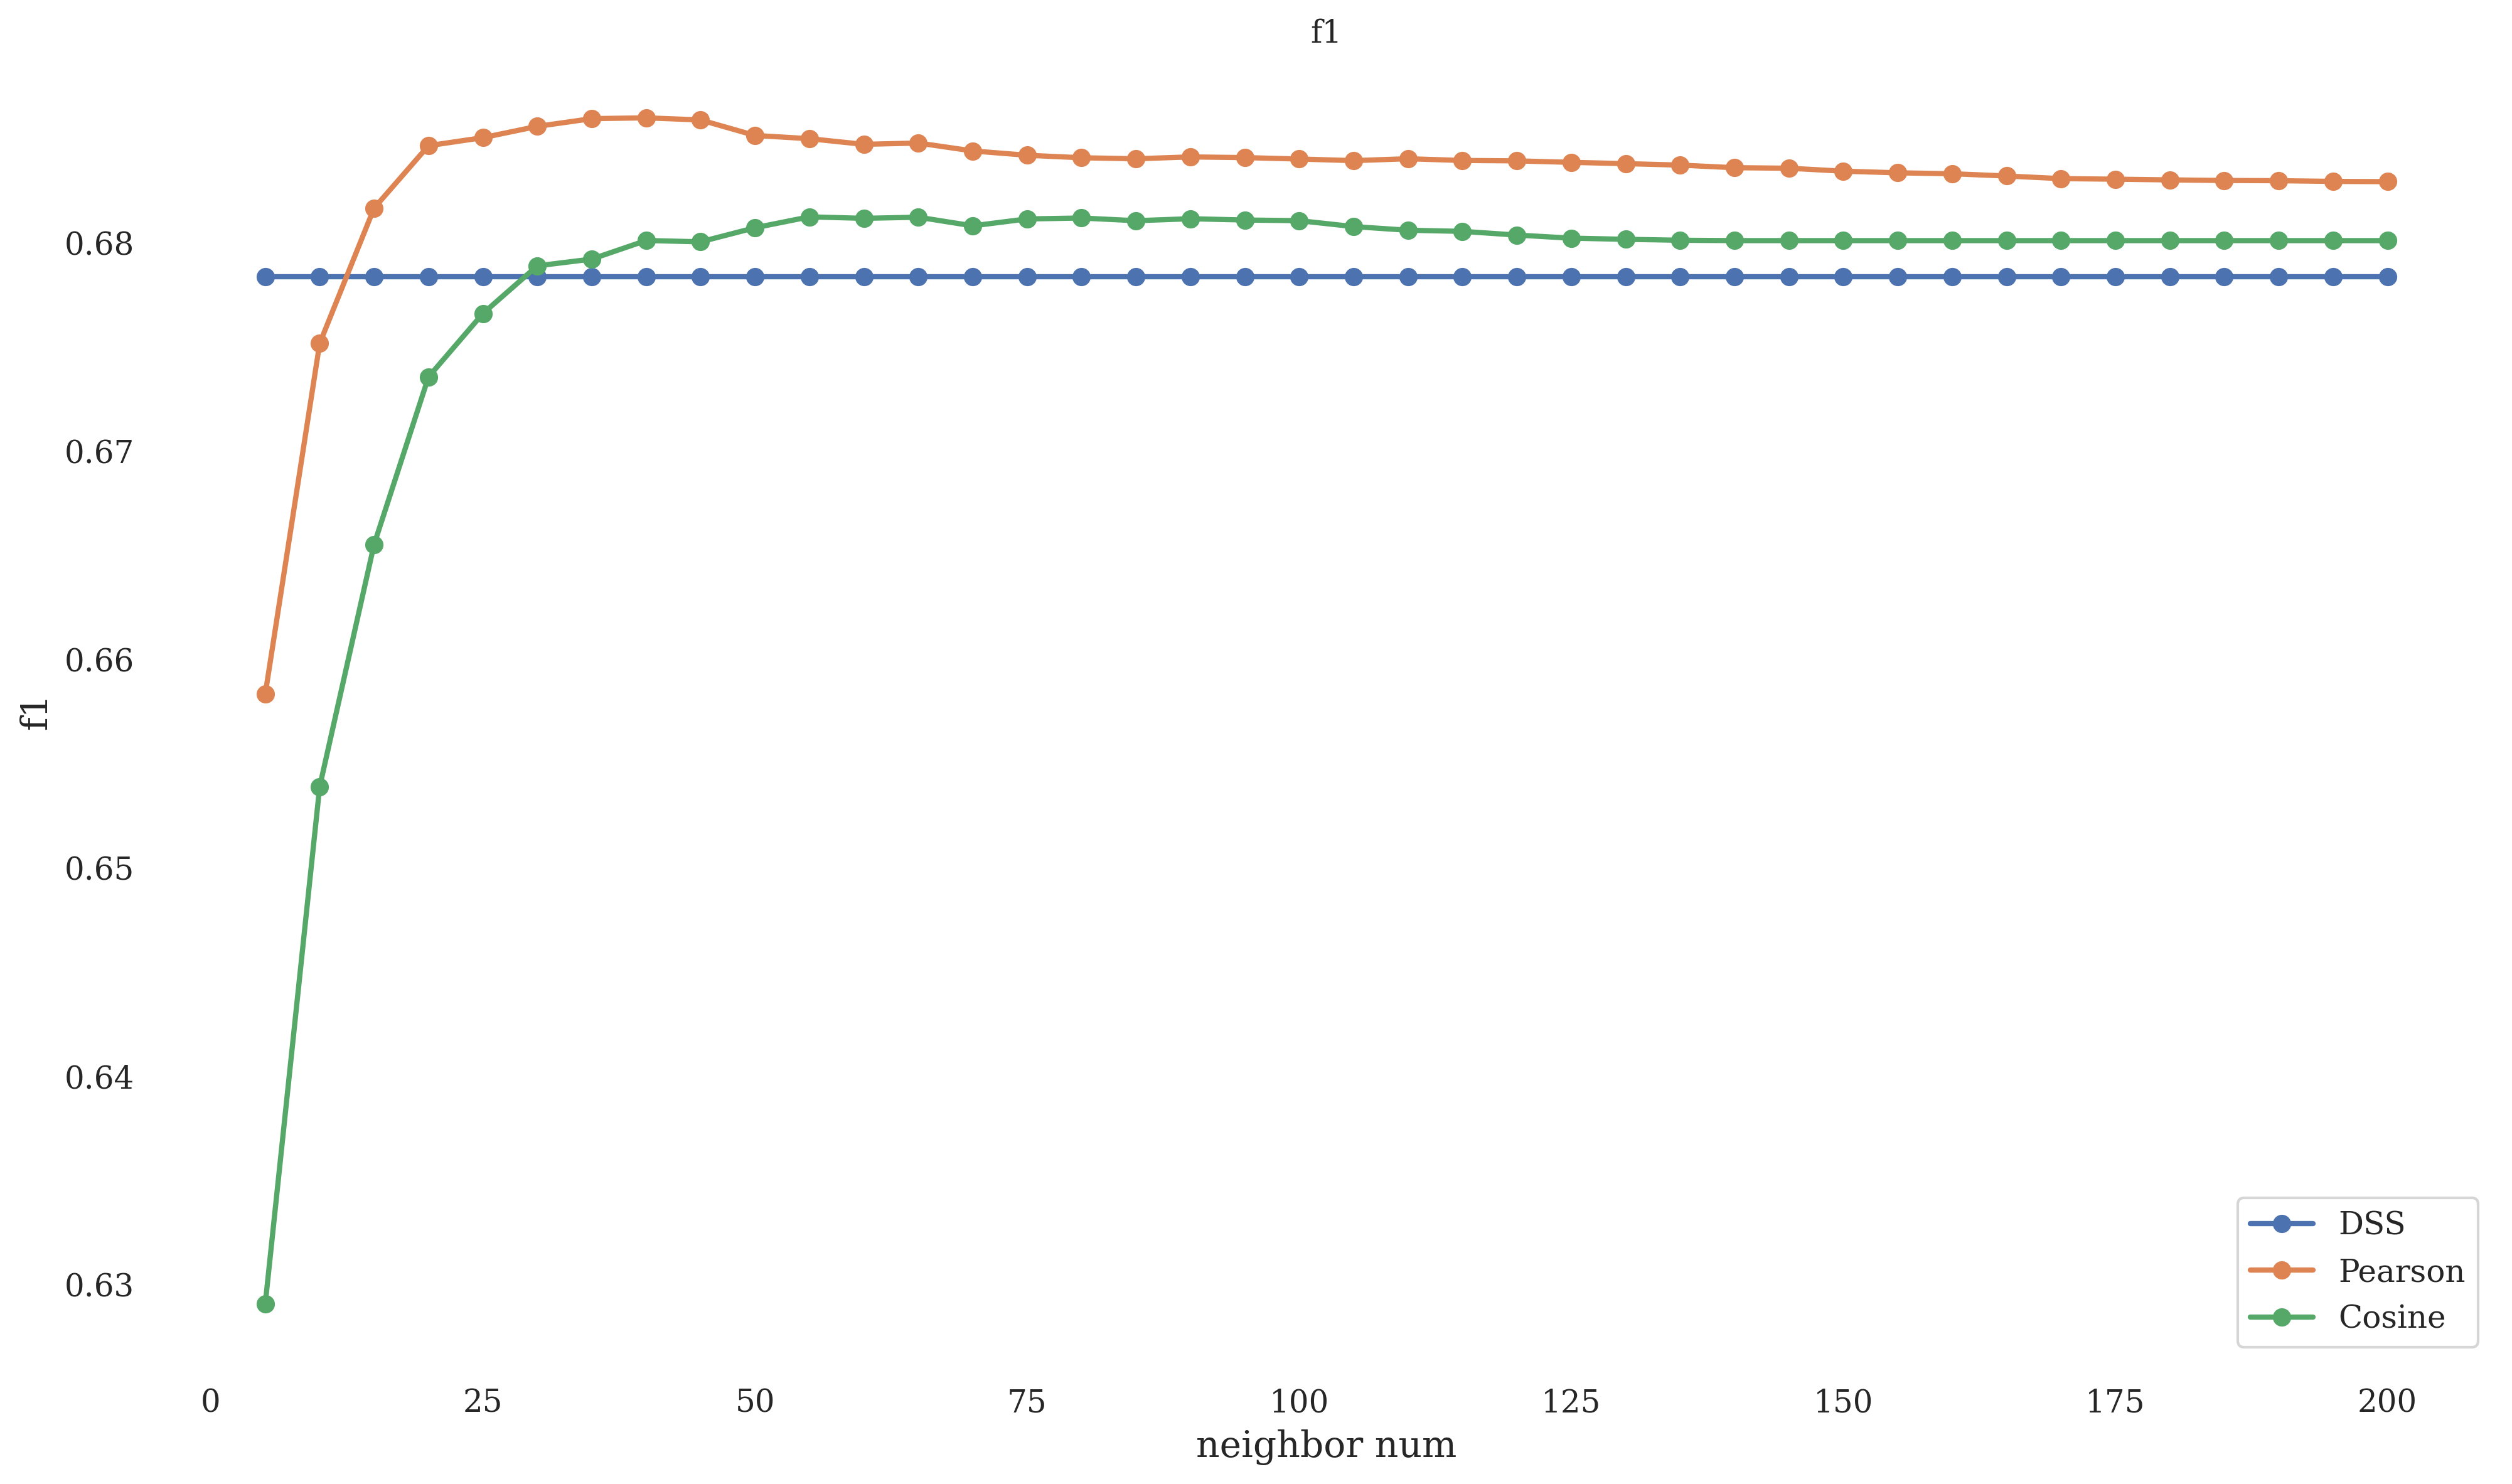

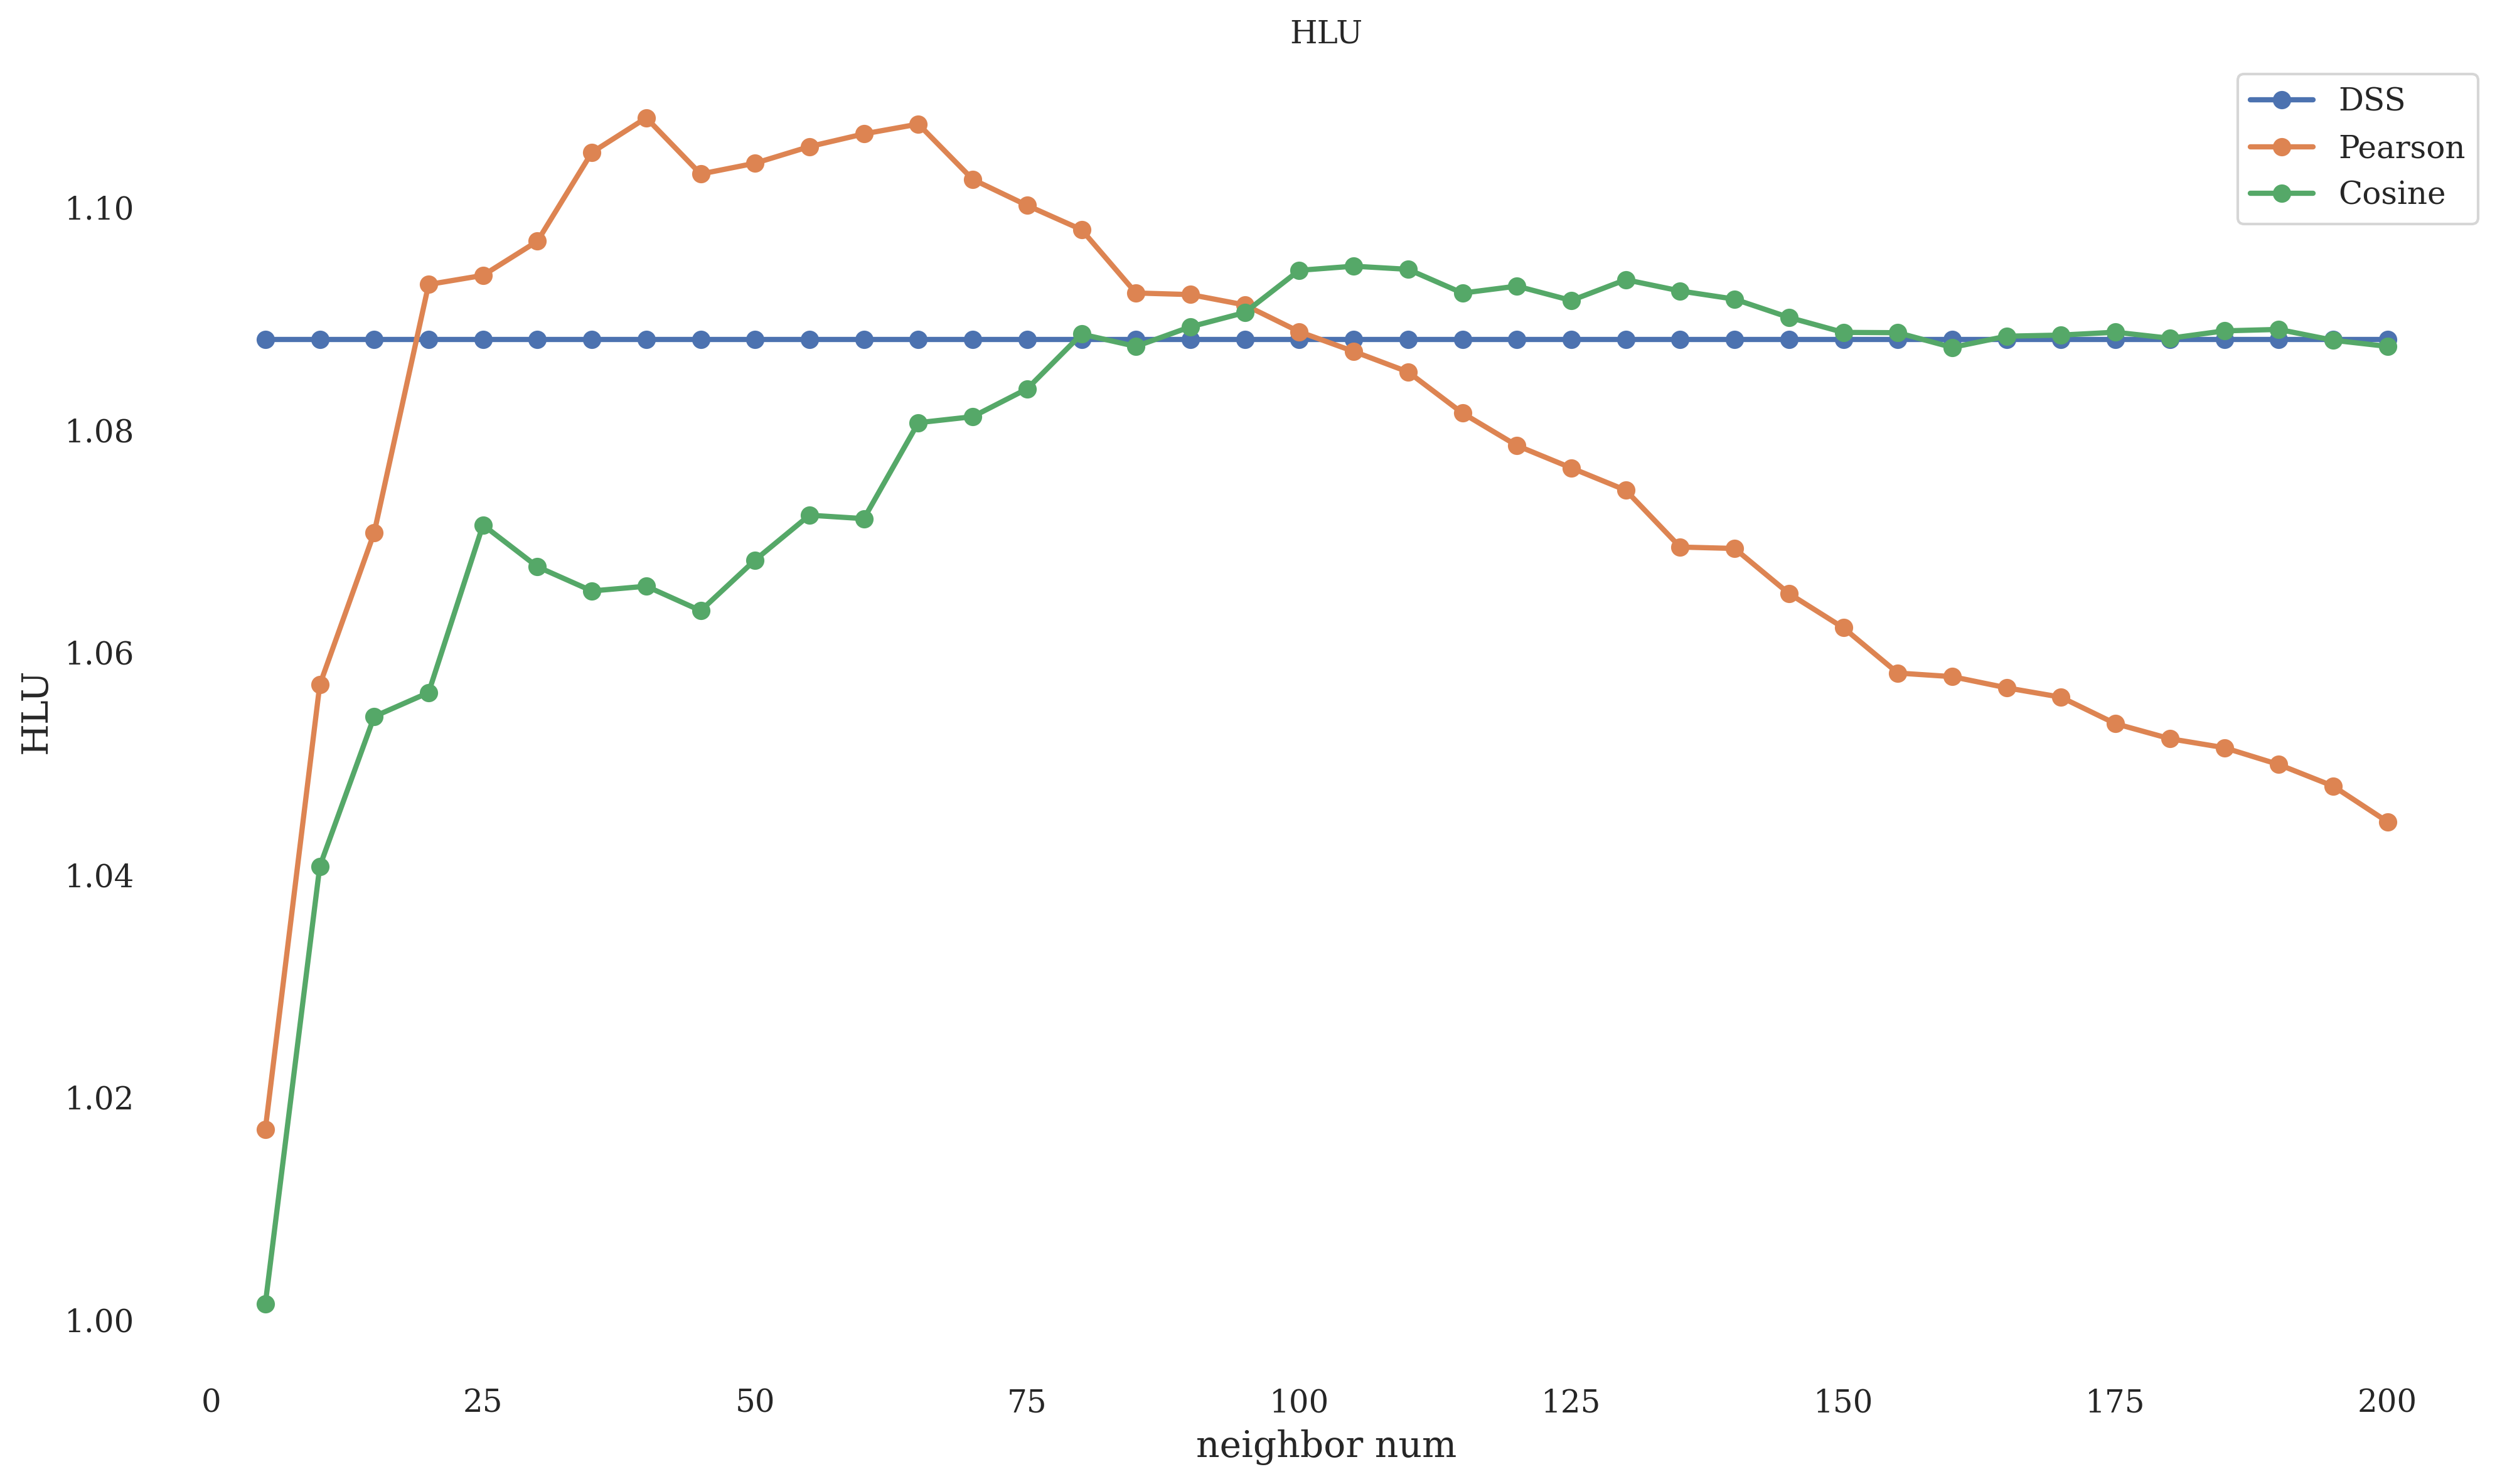

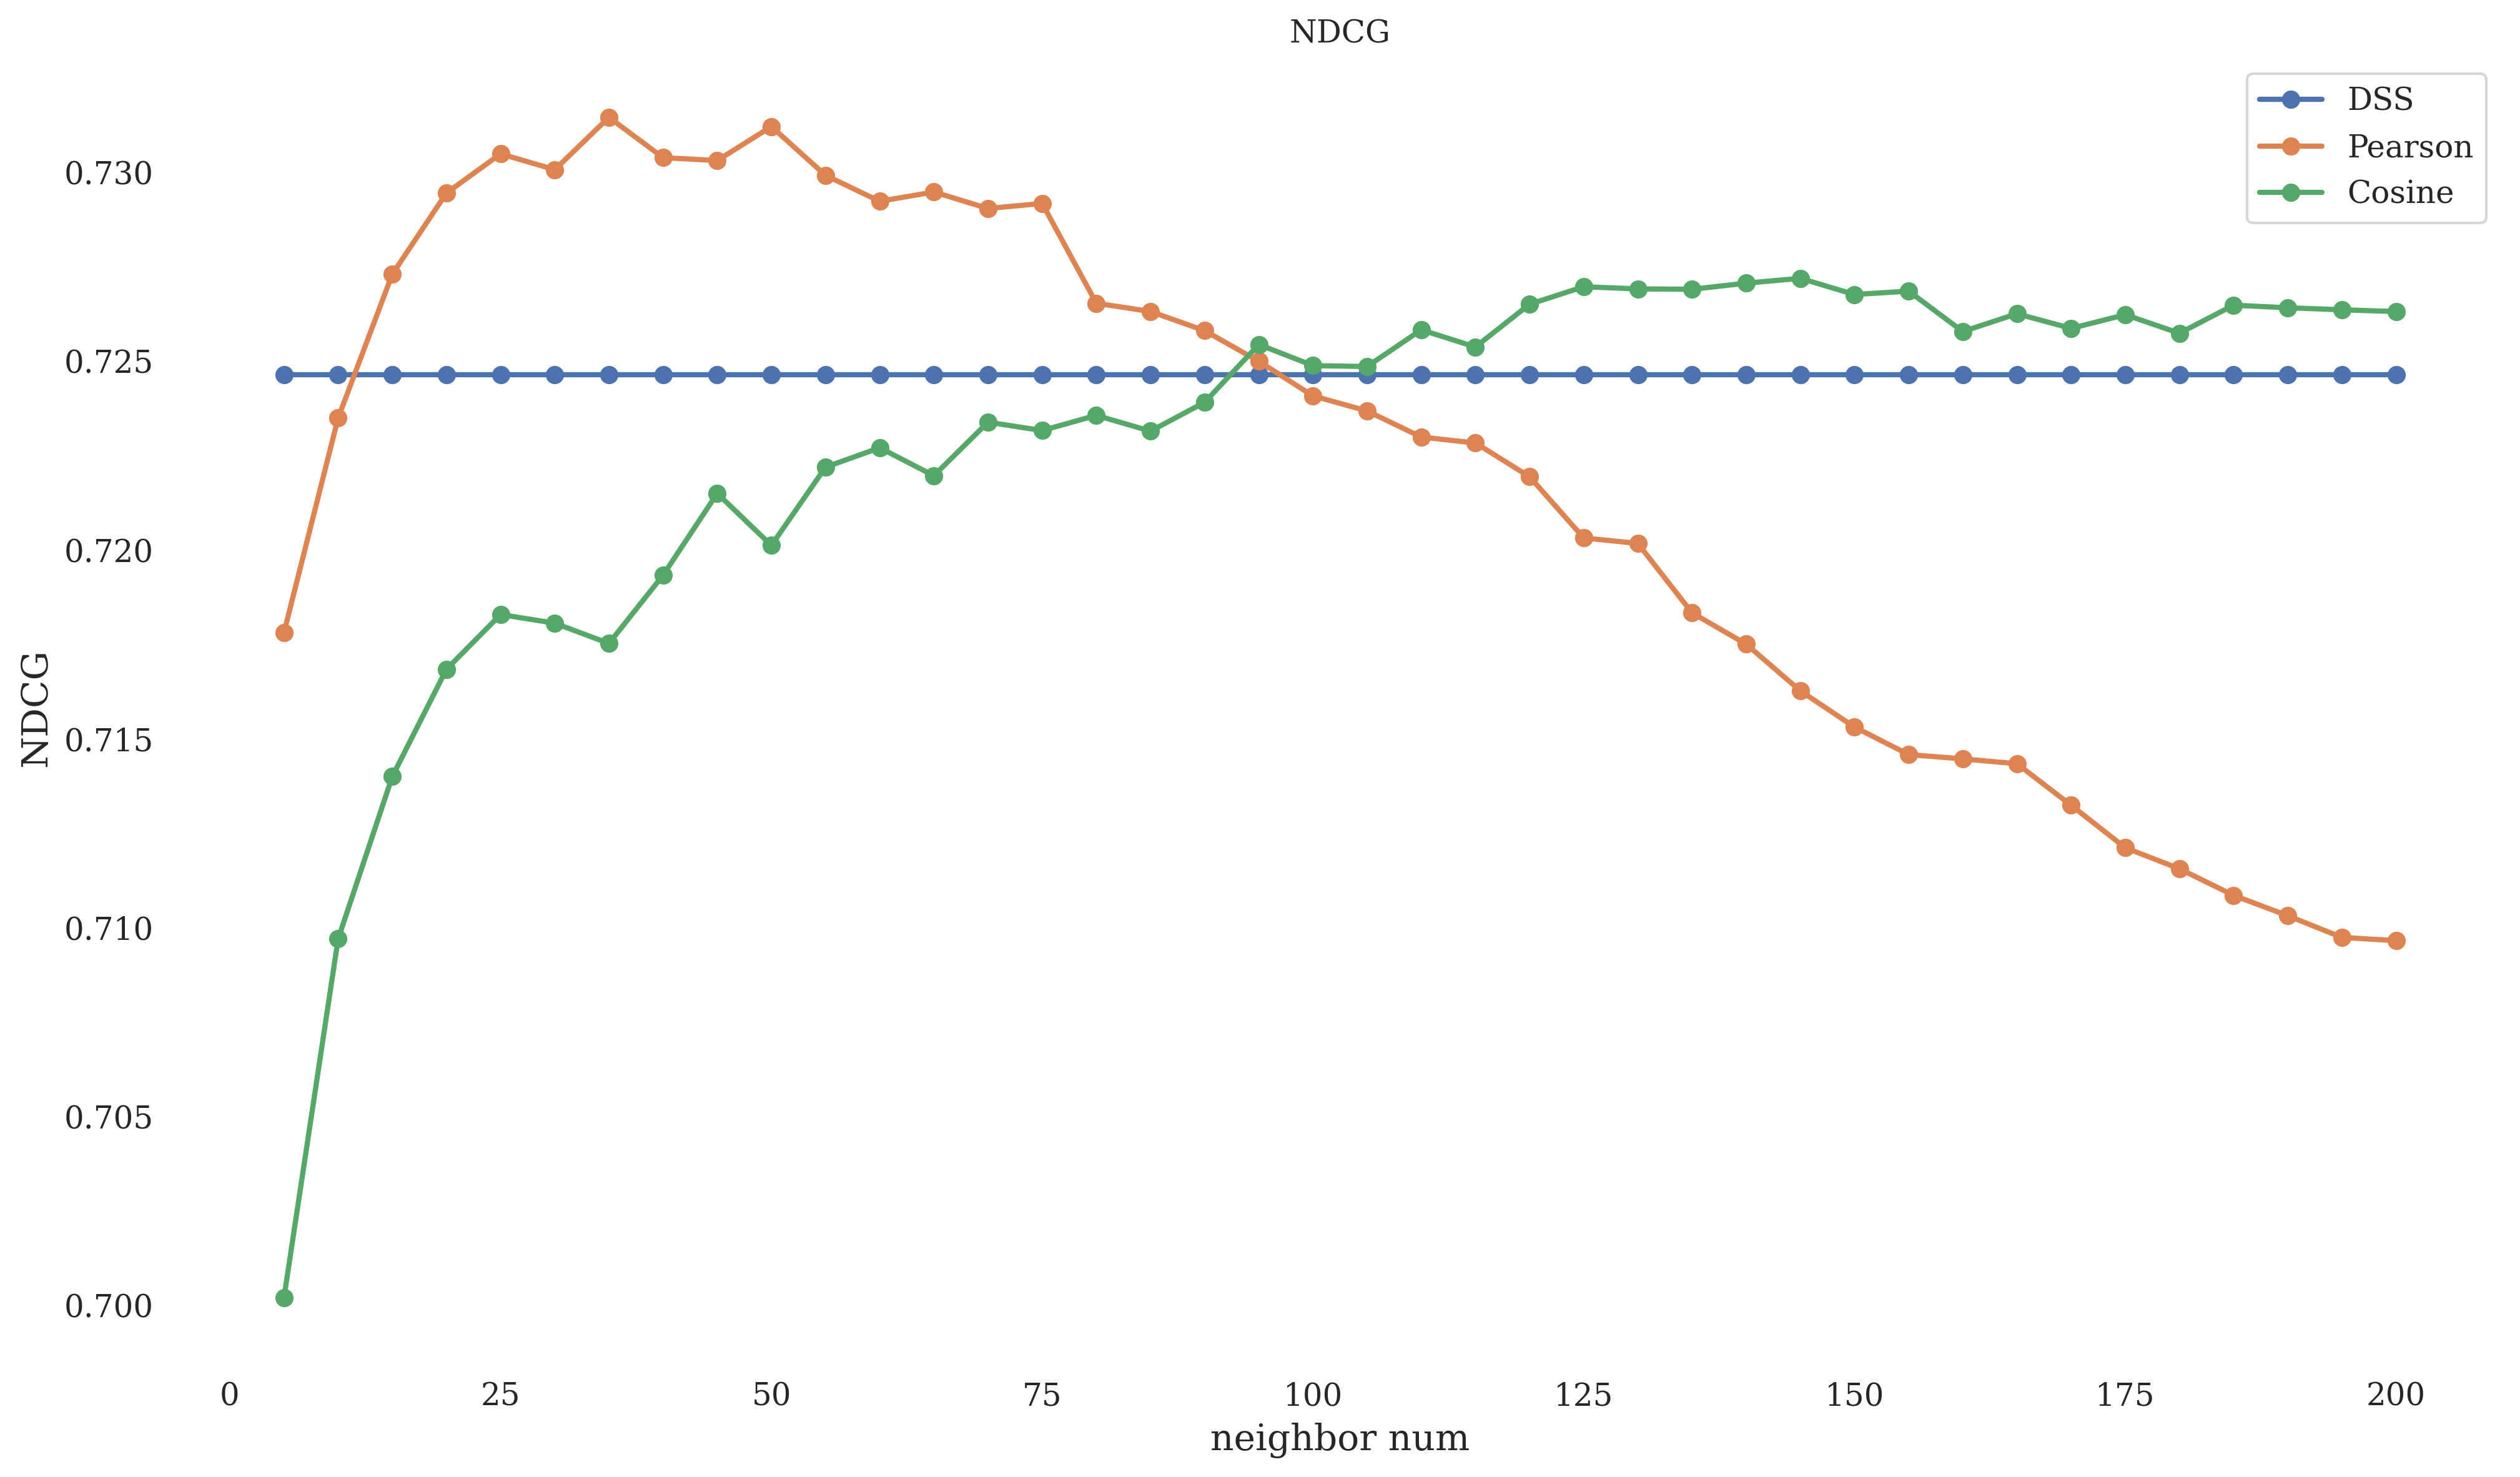

In [39]:
plot(neighbor_nums, [evaluations_DSS['MAE'], evaluations_Pearson['MAE'], evaluations_Cosine['MAE']], method, 'neighbor num', 'MAE', 'MAE')
plot(neighbor_nums, [evaluations_DSS['RMSE'], evaluations_Pearson['RMSE'], evaluations_Cosine['RMSE']], method, 'neighbor num', 'RMSE', 'RMSE')
plot(neighbor_nums, [evaluations_DSS['accuracy'], evaluations_Pearson['accuracy'], evaluations_Cosine['accuracy']], method, 'neighbor num', 'accuracy', 'accuracy')
plot(neighbor_nums, [evaluations_DSS['precision'], evaluations_Pearson['precision'], evaluations_Cosine['precision']], method, 'neighbor num', 'precision', 'precision')
plot(neighbor_nums, [evaluations_DSS['recall'], evaluations_Pearson['recall'], evaluations_Cosine['recall']], method, 'neighbor num', 'recall', 'recall')
plot(neighbor_nums, [evaluations_DSS['f1'], evaluations_Pearson['f1'], evaluations_Cosine['f1']], method, 'neighbor num', 'f1', 'f1')
plot(neighbor_nums, [evaluations_DSS['HLU'], evaluations_Pearson['HLU'], evaluations_Cosine['HLU']], method, 'neighbor num', 'HLU', 'HLU')
plot(neighbor_nums, [evaluations_DSS['NDCG'], evaluations_Pearson['NDCG'], evaluations_Cosine['NDCG']], method, 'neighbor num', 'NDCG', 'NDCG')